# `CredX Case Study`
*The purpose of this assignment is to develop a classification model which should serve purposes:*
 - It will be used to identify the right applicant

## Step 1: Importing packages, Reading & Understanding Data

In [1]:
# Importing all required packages
import numpy as np
import pandas as pd
from datetime import datetime as dt
import scipy.stats as stats
from scipy.stats import norm, skew #for some statistics
import re

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib

# To Scale our data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# For building model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_mldata
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [3]:
# Reading the Demographic data
demographic = pd.read_csv("Demographic data.csv", sep=",")
demographic.head()

,Application ID,Age,Gender,Marital Status (at the time of application),No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,Performance Tag
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000


In [4]:
# Checking the datatypes
demographic.dtypes

Application ID                                   int64
Age                                              int64
Gender                                          object
Marital Status (at the time of application)     object
No of dependents                               float64
Income                                         float64
Education                                       object
Profession                                      object
Type of residence                               object
No of months in current residence                int64
No of months in current company                  int64
Performance Tag                                float64
dtype: object

In [5]:
# Chaecking the shape of data frame
demographic.shape

(71295, 12)

In [6]:
# Print the Column name
demographic.columns

Index(['Application ID', 'Age', 'Gender',
       'Marital Status (at the time of application)', 'No of dependents',
       'Income', 'Education', 'Profession ', 'Type of residence',
       'No of months in current residence', 'No of months in current company',
       'Performance Tag'],
      dtype='object')

In [7]:
# Few column name contains the space and special charc so removing those chars
demographic.columns = demographic.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [8]:
# Keeping copy of Orignal data set for later use
demographic_copy=demographic.copy()

In [9]:
demographic_copy.head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000


### Handling Duplicate Rows

In [10]:
# removing duplicate rows
demographic.drop_duplicates(subset='application_id')
demographic.shape

(71295, 12)

In [11]:
# There are duplicate application_id in data frame
print(any(demographic['application_id'].duplicated())) 

True


In [12]:
# Print the duplicate rows
demographic[demographic.duplicated(['application_id'])]

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
27586,765011468,38,M,Married,4.000,4.500,Professional,SAL,Rented,6,72,0.000
42637,653287861,40,M,Married,5.000,32.000,Phd,SE,Rented,45,46,1.000
59022,671989187,57,M,Married,4.000,7.000,Professional,SE,Rented,42,3,0.000


In [13]:
demographic.columns

Index(['application_id', 'age', 'gender',
       'marital_status_at_the_time_of_application', 'no_of_dependents',
       'income', 'education', 'profession', 'type_of_residence',
       'no_of_months_in_current_residence', 'no_of_months_in_current_company',
       'performance_tag'],
      dtype='object')

## Step 2: EDA & Data Visualisation

In [14]:
print(demographic.isnull().sum())

application_id                                  0
age                                             0
gender                                          2
marital_status_at_the_time_of_application       6
no_of_dependents                                3
income                                          0
education                                     119
profession                                     14
type_of_residence                               8
no_of_months_in_current_residence               0
no_of_months_in_current_company                 0
performance_tag                              1425
dtype: int64


Cheking the defaults applicant numbers in data set

In [15]:
demographic['performance_tag'].value_counts()

0.000    66922
1.000     2948
Name: performance_tag, dtype: int64

In [16]:
#% of People defaulted

100*(demographic['performance_tag'].sum()/demographic['performance_tag'].count()).round(4)

4.22

### Exploratory Data Analysis

Now, we will do Exploratory Data Analysis on individual features and look for patterns.

### Age

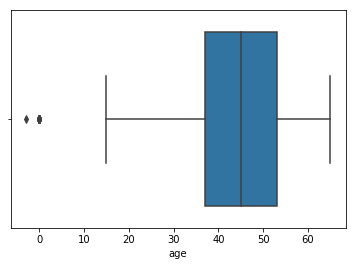

In [17]:
sns.boxplot(x='age', data=demographic)
plt.show()

From the above we can see that few of the age are in negative lets view those records

In [18]:
# we have one record with negative age
demographic[demographic['age']<0]

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
16315,634180637,-3,M,Married,2.000,53.000,Masters,SE_PROF,Rented,6,37,0.000


In [19]:
# the records with age<18 will be minor and wont be applicable for cards
demographic[demographic['age']<18].head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
74,975085624,17,M,Single,2.000,31.000,Bachelor,SAL,Living with Parents,112,50,0.000
250,15988053,17,M,Single,3.000,40.000,Bachelor,SE_PROF,Owned,108,44,1.000
274,553384326,17,M,Single,3.000,19.000,Professional,SAL,Owned,72,54,0.000
283,490791674,15,F,Single,2.000,36.000,Professional,SAL,Rented,112,50,0.000
313,584758872,16,M,Single,2.000,24.000,Bachelor,SAL,Rented,111,43,0.000


In [20]:
# To understand the behaviour of people with age, we are going to bucket the age groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,demographic['age'].max() + 10, 10)
demographic['age_bins'] = pd.cut(demographic['age'], bins, include_lowest=True)

In [21]:
No_of_default = demographic.groupby('age_bins')['performance_tag'].count().reset_index(name = 'No.of_prospect')

In [22]:
count_default = demographic[demographic['performance_tag']==1].groupby('age_bins')['performance_tag'].count().reset_index(name = 'count_default')

In [23]:
agg_age = No_of_default.merge(count_default, on='age_bins')

In [24]:
agg_age['default_rate'] = 100*(agg_age['count_default']/agg_age['No.of_prospect']).round(3)

In [25]:
agg_age

,age_bins,No.of_prospect,count_default,default_rate
0,"(9.999, 20.0]",121,3,2.500
1,"(20.0, 30.0]",5807,238,4.100
2,"(30.0, 40.0]",18690,831,4.400
3,"(40.0, 50.0]",22872,958,4.200
4,"(50.0, 60.0]",17535,718,4.100
5,"(60.0, 70.0]",4825,200,4.100


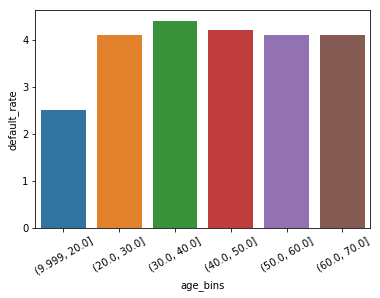

In [26]:
ax = sns.barplot(x='age_bins', y='default_rate', data=agg_age)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

Analysis of gender

In [27]:
demographic['gender'].value_counts()

M    54456
F    16837
Name: gender, dtype: int64

In [28]:
count_prospects_gender = demographic.groupby('gender')['performance_tag'].sum().reset_index(name = 'count_prospects')

In [29]:
No_of_prospect_Gender = demographic.groupby('gender')['performance_tag'].count().reset_index(name = 'No_of_prospects')

In [30]:
agg_gender = count_prospects_gender.merge(No_of_prospect_Gender, on = 'gender')

In [31]:
agg_gender['default_rate'] = 100*(agg_gender['count_prospects']/agg_gender['No_of_prospects']).round(4)

In [32]:
agg_gender

,gender,count_prospects,No_of_prospects,default_rate
0,F,718.000,16506,4.350
1,M,2230.000,53362,4.180


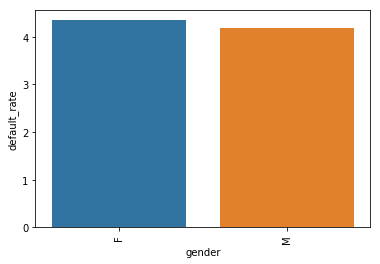

In [33]:
ax = sns.barplot(x='gender', y='default_rate', data=agg_gender)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

Marital Status

In [34]:
demographic['marital_status_at_the_time_of_application'].value_counts()

Married    60730
Single     10559
Name: marital_status_at_the_time_of_application, dtype: int64

In [35]:
count_prospects_marital = demographic.groupby('marital_status_at_the_time_of_application')['performance_tag'].sum().reset_index(name = 'count_prospects')

In [36]:
No_of_prospect_job = demographic.groupby('marital_status_at_the_time_of_application')['performance_tag'].count().reset_index(name = 'No_of_prospects')

In [37]:
agg_marital = count_prospects_marital.merge(No_of_prospect_job, on = 'marital_status_at_the_time_of_application')

In [38]:
agg_marital['default_rate'] = 100*(agg_marital['count_prospects']/agg_marital['No_of_prospects']).round(4)

In [39]:
agg_marital

,marital_status_at_the_time_of_application,count_prospects,No_of_prospects,default_rate
0,Married,2503.000,59547,4.200
1,Single,445.000,10317,4.310


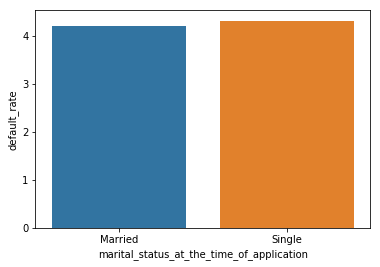

In [40]:
ax = sns.barplot(x='marital_status_at_the_time_of_application', y='default_rate', data=agg_marital)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.show()

No_of_dependents

In [41]:
demographic['no_of_dependents'].value_counts()

3.000    16279
1.000    15387
2.000    15289
4.000    12222
5.000    12115
Name: no_of_dependents, dtype: int64

In [42]:
count_prospects_dependents = demographic.groupby('no_of_dependents')['performance_tag'].sum().reset_index(name = 'count_prospects')

In [43]:
No_of_prospect_dependents = demographic.groupby('no_of_dependents')['performance_tag'].count().reset_index(name = 'No_of_prospects')

In [44]:
agg_dependent = count_prospects_dependents.merge(No_of_prospect_dependents, on = 'no_of_dependents')

In [45]:
agg_dependent['default_rate'] = 100*(agg_dependent['count_prospects']/agg_dependent['No_of_prospects']).round(4)

In [46]:
agg_dependent

,no_of_dependents,count_prospects,No_of_prospects,default_rate
0,1.000,667.000,15218,4.380
1,2.000,588.000,15128,3.890
2,3.000,695.000,15645,4.440
3,4.000,494.000,12000,4.120
4,5.000,504.000,11876,4.240


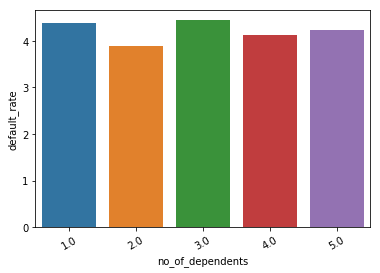

In [47]:
ax = sns.barplot(x='no_of_dependents', y='default_rate', data=agg_dependent)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

Income

In [48]:
demographic['income'].describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

count   71295.000
mean       27.195
std        15.515
min        -0.500
25%        14.000
50%        27.000
75%        40.000
95%        54.000
99%        59.000
max        60.000
Name: income, dtype: float64

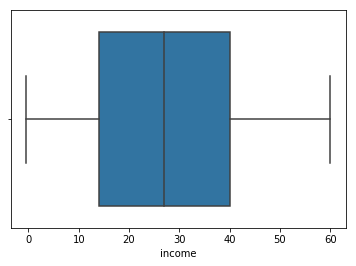

In [49]:
sns.boxplot(x='income', data=demographic)
plt.show()

Education

In [50]:
demographic['education'].value_counts()

Professional    24839
Masters         23970
Bachelor        17697
Phd              4549
Others            121
Name: education, dtype: int64

In [51]:
count_prospects_education = demographic.groupby('education')['performance_tag'].sum().reset_index(name = 'count_prospects')

In [52]:
No_of_prospect_education = demographic.groupby('education')['performance_tag'].count().reset_index(name = 'No_of_prospects')

In [53]:
agg_education = count_prospects_education.merge(No_of_prospect_education, on = 'education')

In [54]:
agg_education['default_rate'] = 100*(agg_education['count_prospects']/agg_education['No_of_prospects']).round(4)

In [55]:
agg_education

,education,count_prospects,No_of_prospects,default_rate
0,Bachelor,742.000,17302,4.290
1,Masters,998.000,23481,4.250
2,Others,8.000,119,6.720
3,Phd,184.000,4464,4.120
4,Professional,1011.000,24386,4.150


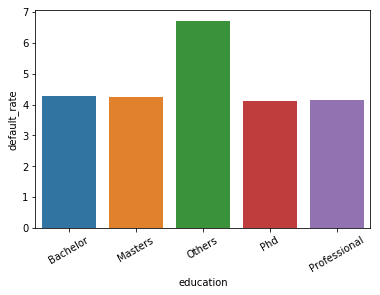

In [56]:
ax = sns.barplot(x='education', y='default_rate', data=agg_education)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

We can note that the others are mode defaults since the number is very less we cannnot make any diffrence 

Profession

In [57]:
demographic['profession'].value_counts()

SAL        40439
SE_PROF    16535
SE         14307
Name: profession, dtype: int64

In [58]:
count_prospects_profession = demographic.groupby('profession')['performance_tag'].sum().reset_index(name = 'count_prospects')

In [59]:
No_of_prospect_profession = demographic.groupby('profession')['performance_tag'].count().reset_index(name = 'No_of_prospects')

In [60]:
agg_Profession = count_prospects_profession.merge(No_of_prospect_profession, on = 'profession')

In [61]:
agg_Profession['default_rate'] = 100*(agg_Profession['count_prospects']/agg_Profession['No_of_prospects']).round(4)

In [62]:
agg_Profession

,profession,count_prospects,No_of_prospects,default_rate
0,SAL,1629.000,39674,4.110
1,SE,642.000,13927,4.610
2,SE_PROF,677.000,16256,4.160


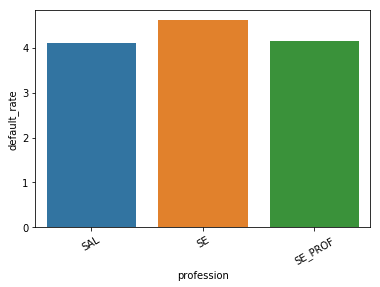

In [63]:
ax = sns.barplot(x='profession', y='default_rate', data=agg_Profession)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

Type_of_residence

In [64]:
demographic['type_of_residence'].value_counts()

Rented                 53397
Owned                  14243
Living with Parents     1818
Company provided        1630
Others                   199
Name: type_of_residence, dtype: int64

In [65]:
count_prospects_Type_of_residence = demographic.groupby('type_of_residence')['performance_tag'].sum().reset_index(name = 'count_prospects')
No_of_prospect_Type_of_residence = demographic.groupby('type_of_residence')['performance_tag'].count().reset_index(name = 'No_of_prospects')
agg_residence = count_prospects_Type_of_residence.merge(No_of_prospect_Type_of_residence, on = 'type_of_residence')
agg_residence['default_rate'] = 100*(agg_residence['count_prospects']/agg_residence['No_of_prospects']).round(4)

In [66]:
agg_residence

,type_of_residence,count_prospects,No_of_prospects,default_rate
0,Company provided,73.000,1603,4.550
1,Living with Parents,80.000,1778,4.500
2,Others,5.000,198,2.530
3,Owned,593.000,14003,4.230
4,Rented,2197.000,52280,4.200


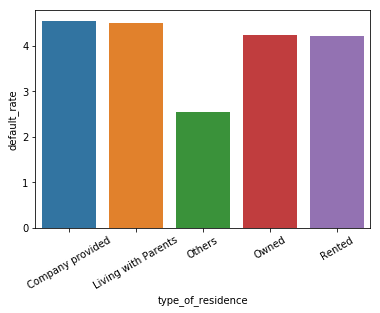

In [67]:
ax = sns.barplot(x='type_of_residence', y='default_rate', data=agg_residence)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

In [68]:
demographic['no_of_months_in_current_residence'].value_counts()

6      33966
14       454
8        424
18       423
12       422
10       412
11       408
7        403
29       403
9        402
15       398
33       393
13       392
22       390
40       388
17       386
21       381
16       379
39       378
20       373
35       372
31       372
38       371
45       369
19       368
25       367
27       366
34       364
42       360
30       359
       ...  
110      280
98       280
99       280
115      280
89       279
105      278
69       274
80       272
104      272
90       270
111      269
113      268
108      268
96       266
92       263
97       262
86       257
77       256
87       256
85       249
117      199
122      190
119      185
118      185
120      182
121      176
123      156
126      145
125      141
124      135
Name: no_of_months_in_current_residence, Length: 121, dtype: int64

In [69]:
bins = np.arange(10,demographic['no_of_months_in_current_residence'].max() + 10, 10)
demographic['experance_bins'] = pd.cut(demographic['no_of_months_in_current_residence'], bins, include_lowest=True)

In [70]:
No_of_prospect = demographic.groupby('experance_bins')['performance_tag'].count().reset_index(name = 'No.of_prospect')

In [71]:
count_prospects = demographic[demographic['performance_tag']==1].groupby('experance_bins')['performance_tag'].count().reset_index(name = 'count_prospects')

In [72]:
agg_residence = No_of_prospect.merge(count_prospects, on='experance_bins')

In [73]:
agg_residence['default_rate'] = 100*(agg_residence['count_prospects']/agg_residence['No.of_prospect']).round(3)

In [74]:
agg_residence

,experance_bins,No.of_prospect,count_prospects,default_rate
0,"(9.999, 20.0]",4166,287,6.900
1,"(20.0, 30.0]",3482,229,6.600
2,"(30.0, 40.0]",3524,200,5.700
3,"(40.0, 50.0]",3300,179,5.400
4,"(50.0, 60.0]",3167,168,5.300
5,"(60.0, 70.0]",2907,129,4.400
6,"(70.0, 80.0]",2821,137,4.900
7,"(80.0, 90.0]",2742,126,4.600
8,"(90.0, 100.0]",2782,119,4.300
9,"(100.0, 110.0]",2889,108,3.700


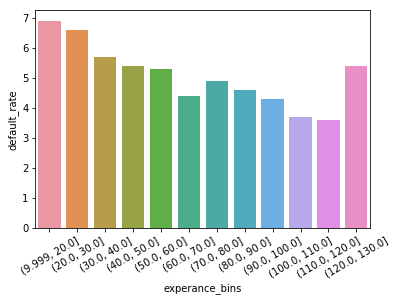

In [75]:
ax = sns.barplot(x='experance_bins', y='default_rate', data=agg_residence)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

No_of_months_in_current_company

In [76]:
demographic['no_of_months_in_current_company'].value_counts()

3      4957
27     1098
38     1087
44     1081
5      1070
54     1069
40     1069
57     1069
53     1069
43     1062
12     1062
48     1057
24     1056
51     1053
41     1052
55     1051
45     1047
29     1045
13     1041
52     1041
7      1039
46     1038
58     1038
31     1037
19     1036
36     1035
56     1034
39     1034
42     1033
6      1032
       ... 
21      973
47      973
11      942
62      900
60      895
59      885
61      841
71      510
65      510
63      501
64      500
67      494
70      485
69      477
72      474
66      474
68      467
73      461
75      459
74      409
83        1
91        1
126       1
96        1
133       1
98        1
105       1
121       1
123       1
128       1
Name: no_of_months_in_current_company, Length: 83, dtype: int64

In [77]:
bins = np.arange(10,demographic['no_of_months_in_current_company'].max() + 10, 10)
demographic['current_company_bins'] = pd.cut(demographic['no_of_months_in_current_company'], bins, include_lowest=True)

In [78]:
No_of_prospect = demographic.groupby('current_company_bins')['performance_tag'].count().reset_index(name = 'No.of_prospect')

In [79]:
count_prospects = demographic[demographic['performance_tag']==1].groupby('current_company_bins')['performance_tag'].count().reset_index(name = 'count_prospects')

In [80]:
agg_current_company = No_of_prospect.merge(count_prospects, on='current_company_bins')

In [81]:
agg_current_company['default_rate'] = 100*(agg_current_company['count_prospects']/agg_current_company['No.of_prospect']).round(3)

In [82]:
agg_current_company

,current_company_bins,No.of_prospect,count_prospects,default_rate
0,"(9.999, 20.0]",10808,539,5.000
1,"(20.0, 30.0]",10046,414,4.100
2,"(30.0, 40.0]",10198,432,4.200
3,"(40.0, 50.0]",10256,386,3.800
4,"(50.0, 60.0]",10119,320,3.200
5,"(60.0, 70.0]",5578,236,4.200
6,"(70.0, 80.0]",2281,110,4.800
7,"(80.0, 90.0]",1,0,0.000
8,"(90.0, 100.0]",3,0,0.000
9,"(100.0, 110.0]",1,0,0.000


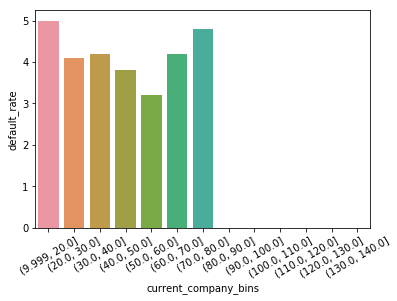

In [83]:
ax = sns.barplot(x='current_company_bins', y='default_rate', data=agg_current_company)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

Model Building

#### Data Preparation

Once Exploratory Data anlysis has been performed, we move to data preparation for the purpose of modelling.

In [84]:
demographic.head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag,age_bins,experance_bins,current_company_bins
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000,"(40.0, 50.0]","(110.0, 120.0]","(50.0, 60.0]"
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000,"(30.0, 40.0]","(110.0, 120.0]","(40.0, 50.0]"
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000,"(30.0, 40.0]","(100.0, 110.0]","(40.0, 50.0]"
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000,"(40.0, 50.0]","(90.0, 100.0]","(50.0, 60.0]"
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000,"(30.0, 40.0]","(110.0, 120.0]","(40.0, 50.0]"


In [85]:
demographic=demographic_copy.copy()

In [86]:
# Identifying if any column exists with only null values
demographic.isnull().all(axis=0).any()

False

In [87]:
demographic.shape

(71295, 12)

In [88]:
# There are duplicate application_id in data frame
print(any(demographic['application_id'].duplicated())) 

True


In [89]:
# Dropping the duplicates keeping first
m = ~demographic['application_id'].duplicated(keep='first')
demographic=demographic[m]

In [90]:
demographic.shape

(71292, 12)

In [91]:
demographic.head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000


In [92]:
# Checking for null values
print(demographic.isnull().sum())

application_id                                  0
age                                             0
gender                                          2
marital_status_at_the_time_of_application       6
no_of_dependents                                3
income                                          0
education                                     119
profession                                     14
type_of_residence                               8
no_of_months_in_current_residence               0
no_of_months_in_current_company                 0
performance_tag                              1425
dtype: int64


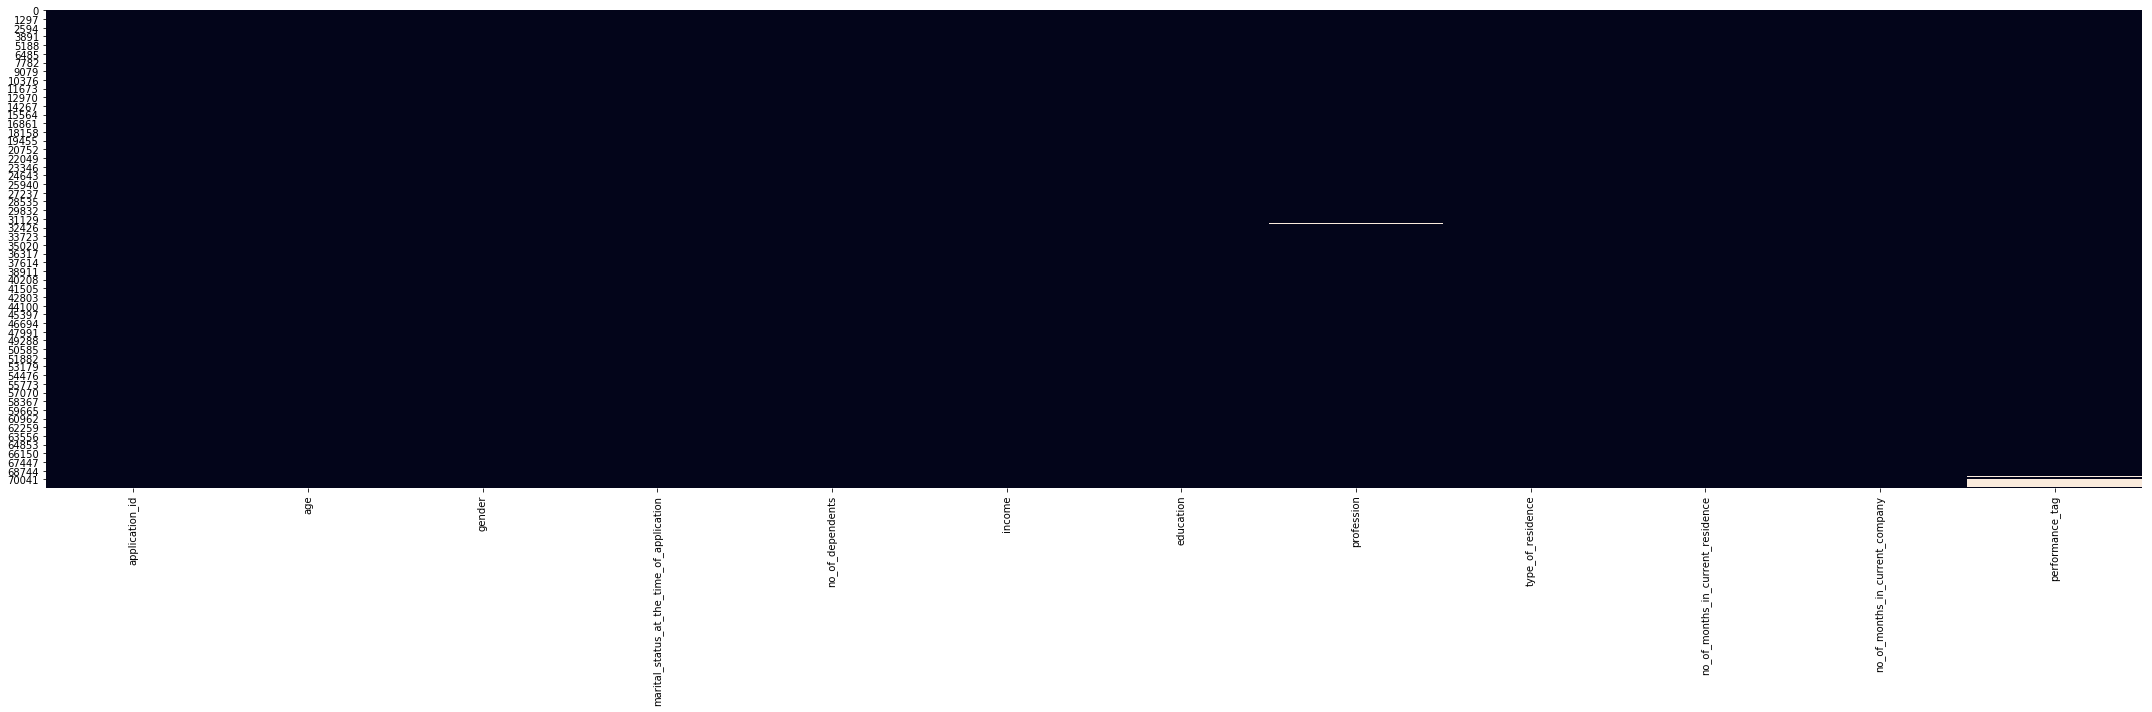

In [93]:
### *Visualizing occurence of Null values in the columns based on rows*
plt.figure(figsize=(30,10))
sns.heatmap(demographic.isnull(), cbar=False)

plt.tight_layout()
plt.show()

In [94]:
# Dropping all columns with only 0 values
demographic.loc[:, (demographic != 0).any(axis=0)]
demographic.shape

(71292, 12)

In [95]:
#Remove columns which has only one unique value

demographic= demographic.loc[:,demographic.nunique()!=1]
demographic.shape

(71292, 12)

In [96]:
#marital_status_at_the_time_of_application has 6 null values removing it
demographic=demographic[demographic.marital_status_at_the_time_of_application.notnull()]

In [97]:
# Gender has only 2 NA values, removing that rows
demographic=demographic[demographic.gender.notnull()]

In [98]:
# no_of_dependents has 3 null values removing it
demographic=demographic[demographic.no_of_dependents.notnull()]

In [99]:
# type_of_residence has 8 null value removing it
demographic=demographic[demographic.type_of_residence.notnull()]

In [100]:
# profession has 14 null values removing it
demographic=demographic[demographic.profession.notnull()]

In [101]:
# Filling all null in education with unknown
demographic['education'] = demographic['education'].fillna('unknown')

In [102]:
# All performance tag null to one data frmae
demographic_pnull=demographic[demographic.performance_tag.isnull()]
demographic_pnull.head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
69603,906908303,35,M,Single,1.000,6.000,Bachelor,SAL,Rented,22,18,nan
69604,10990583,47,F,Married,4.000,12.000,Masters,SE,Rented,122,25,nan
69605,589678446,46,M,Married,3.000,7.000,Professional,SE,Rented,10,31,nan
69606,809411322,41,M,Married,3.000,18.000,Masters,SAL,Rented,6,47,nan
69607,150246616,42,F,Married,4.000,17.000,Phd,SAL,Rented,8,49,nan


In [103]:
# All performance tag not null to one data frmae
demographic_pnotnull=demographic[demographic.performance_tag.notnull()]
demographic_pnotnull.head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000


##  Default Rate

In [104]:
#% of People defaulted

100*(demographic_pnotnull['performance_tag'].sum()/demographic_pnotnull['performance_tag'].count()).round(4)

4.22

#### With just 4.22% default rate, there is a high class imbalance. This will cause our classification modelss to have a low predictive accuracy for the minority class

*This means, our predictive model will not be able to predict Customers who might default with high accuracy.*

In [105]:
demographic_pnotnull['performance_tag'].value_counts()

0.000    66889
1.000     2947
Name: performance_tag, dtype: int64

In [106]:
demographic_upsampled=demographic_pnotnull.copy()

In [107]:
# Checking for null values
print(demographic_upsampled.isnull().sum())

application_id                               0
age                                          0
gender                                       0
marital_status_at_the_time_of_application    0
no_of_dependents                             0
income                                       0
education                                    0
profession                                   0
type_of_residence                            0
no_of_months_in_current_residence            0
no_of_months_in_current_company              0
performance_tag                              0
dtype: int64


In [108]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [109]:
iv, woe = iv_woe(data = demographic_upsampled, target = 'performance_tag', bins=10, show_woe = False)
iv.head()

,Variable,IV
0,application_id,0.002
0,age,0.004
0,gender,0.000
0,marital_status_at_the_time_of_application,0.000
0,no_of_dependents,0.003


Information Value 	Variable Predictiveness

Less than 0.02 	Not useful for prediction

0.02 to 0.1 	Weak predictive Power

0.1 to 0.3 	Medium predictive Power

0.3 to 0.5 	Strong predictive Power

0.5 	Suspicious Predictive Power

In [110]:
# print Information value
df = pd.DataFrame(columns=['Feature name', 'Information value', 'strength'])
i=0;
for index,row in iv.iterrows():
    strength='Not useful';
    if(row['IV']>=.02 and row['IV']<.1):
        strength='Weak';
    elif(row['IV']>=.1 and row['IV']<.3):
        strength='Medium';
    elif(row['IV']>=.3 and row['IV']<=.5):
        strength=' Strong';
    elif(row['IV']>.5):
        strength='Suspicious';
    #print(row['Variable'],row['IV'],strength)
    df.loc[i] = [row['Variable'],row['IV'],strength]
    i=i+1;
#df
df.sort_values('Information value',ascending=False)

,Feature name,Information value,strength
9,no_of_months_in_current_residence,0.071,Weak
5,income,0.043,Weak
10,no_of_months_in_current_company,0.023,Weak
1,age,0.004,Not useful
4,no_of_dependents,0.003,Not useful
7,profession,0.002,Not useful
0,application_id,0.002,Not useful
8,type_of_residence,0.001,Not useful
6,education,0.001,Not useful
2,gender,0.000,Not useful


#### From the WOE analysis we found only 3 columns has Weak predictive Power we can use for analysis
#### We will use these three columns to build model

In [111]:
# WOE values
woe.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,application_id,"(100449.999, 99489924.0]",6984,292.000,0.099,6692.000,0.100,-0.010,0.000
1,application_id,"(99489924.0, 199433806.0]",6984,276.000,0.094,6708.000,0.100,-0.068,0.000
2,application_id,"(199433806.0, 298517006.5]",6983,305.000,0.103,6678.000,0.100,0.036,0.000
3,application_id,"(298517006.5, 399368955.0]",6984,295.000,0.100,6689.000,0.100,0.001,0.000
4,application_id,"(399368955.0, 497955643.5]",6983,312.000,0.106,6671.000,0.100,0.060,0.000


In [112]:
columns_model=['no_of_months_in_current_residence','no_of_months_in_current_company','income']
columns_model.append("performance_tag")
columns_model

['no_of_months_in_current_residence',
 'no_of_months_in_current_company',
 'income',
 'performance_tag']

In [113]:
model_data=demographic_upsampled[columns_model]
model_data.head()

,no_of_months_in_current_residence,no_of_months_in_current_company,income,performance_tag
0,113,56,40.000,0.000
1,112,46,55.000,0.000
2,104,49,46.000,0.000
3,94,53,53.000,0.000
4,112,43,44.000,0.000


In [114]:
columns_model.remove('performance_tag')
columns_model

['no_of_months_in_current_residence',
 'no_of_months_in_current_company',
 'income']

In [115]:
def woe_replace(columnvalue, columnname):
    #print(columnvalue,columnname)
    for index1,row1 in woe.iterrows():
        if(row1['Variable']==columnname):
            if(type(row1['Cutoff']).__name__=='Interval'):
                if(columnvalue>row1['Cutoff'].left and columnvalue<=row1['Cutoff'].right):
                    #print("WOE range",row1['Cutoff'],"DF value",columnvalue,"EOE value",row1['WoE']);
                    return row1['WoE'];
            else:
                if(row1['Cutoff']==columnvalue):
                    #print("WOE range",row1['Cutoff'],"DF value",columnvalue,"EOE value",row1['WoE']);
                    return row1['WoE'];
                
    return 0

In [116]:
for str in columns_model:
    print(str)
    model_data[str] = model_data.apply(lambda row : woe_replace(row[str], 
                                  str), axis = 1) 

no_of_months_in_current_residence
no_of_months_in_current_company
income


As above information value we can see that non of the varaible fall under the range of predictiveness

In [117]:
model_data.head()

,no_of_months_in_current_residence,no_of_months_in_current_company,income,performance_tag
0,-0.069,-0.229,-0.273,0.000
1,-0.069,-0.149,-0.385,0.000
2,-0.069,-0.255,-0.169,0.000
3,0.122,-0.255,-0.385,0.000
4,-0.069,-0.149,-0.169,0.000


In [118]:
print(model_data.isnull().sum())

no_of_months_in_current_residence    0
no_of_months_in_current_company      0
income                               0
performance_tag                      0
dtype: int64


### Model Building using Actual data

In [119]:
# Import library to split the dataset into test and train

from sklearn.model_selection import train_test_split

In [120]:
# Putting feature variable to X
X = model_data.drop(['performance_tag'],axis=1)

# Putting response variable to y
y = model_data['performance_tag']

In [121]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [122]:
import statsmodels.api as sm

In [123]:
# Importing LogisticRegression and metrics from sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [124]:
# Fitting the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        performance_tag   No. Observations:                48885
Model:                            GLM   Df Residuals:                    48881
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8489.0
Date:                Sat, 14 Sep 2019   Deviance:                       16978.
Time:                        18:54:30   Pearson chi2:                 4.90e+04
No. Iterations:                     6   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.1120      0.023   -136.705      0.000      -3.157      -3.067
no_of_months_in_current_residence     0.9192      0.083     11.024      0.000       0.756       1.083
no_of_months_in_current_company       1.0122      0.152      6.678      0.000       0.715       1.309
income                                0.9175      0.110      8.367      0.000       0.703       1.132
=====================================================================================================
"""

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train, y=y_train)

test_y_pred = logisticRegr.predict(X_test)
accuracy =  metrics.accuracy_score(y_test, test_y_pred)
print("accuracy:", accuracy)
print(classification_report(y_test, test_y_pred))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test, y_pred=test_y_pred)
print(cmlr)

accuracy: 0.9589518400076369
             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     20091
        1.0       0.00      0.00      0.00       860

avg / total       0.92      0.96      0.94     20951

[[20091     0]
 [  860     0]]


### Model Building using Over Sample Data

### Over-sampling the minority class

This will create synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class.

In [127]:
model_data['performance_tag'].value_counts()

0.000    66889
1.000     2947
Name: performance_tag, dtype: int64

In [128]:
from sklearn.utils import resample

demographic_majority = model_data[model_data['performance_tag']==0]
demographic_minority = model_data[model_data['performance_tag']==1]

demographic_minority_upsampled = resample(demographic_minority,
replace=True,
n_samples=66889, #same number of samples as majority class
random_state=1) #set the seed for random resampling
# Combine resampled results
demographic_upsampled = pd.concat([demographic_majority, demographic_minority_upsampled])

demographic_upsampled['performance_tag'].value_counts()

1.000    66889
0.000    66889
Name: performance_tag, dtype: int64

In [129]:
# Import library to split the dataset into test and train

from sklearn.model_selection import train_test_split

In [130]:
# Putting feature variable to X
X = demographic_upsampled.drop(['performance_tag'],axis=1)

# Putting response variable to y
y = demographic_upsampled['performance_tag']

In [131]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [132]:
X_train.head()

,no_of_months_in_current_residence,no_of_months_in_current_company,income
42682,-0.069,-0.149,0.079
3853,-0.069,-0.149,-0.013
60190,0.122,-0.229,0.354
6864,0.474,-0.229,-0.147
6837,0.303,0.183,-0.169


In [133]:
import statsmodels.api as sm

In [134]:
# Importing LogisticRegression and metrics from sklearn library
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [135]:
# Fitting the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [136]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        performance_tag   No. Observations:                93644
Model:                            GLM   Df Residuals:                    93640
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63476.
Date:                Sat, 14 Sep 2019   Deviance:                   1.2695e+05
Time:                        18:54:31   Pearson chi2:                 9.36e+04
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.0045      0.007     -0.678      0.498      -0.018       0.009
no_of_months_in_current_residence     0.9101      0.025     36.078      0.000       0.861       0.960
no_of_months_in_current_company       0.9091      0.044     20.603      0.000       0.823       0.996
income                                0.8674      0.032     26.765      0.000       0.804       0.931
=====================================================================================================
"""

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train, y=y_train)

test_y_pred = logisticRegr.predict(X_test)
accuracy =  metrics.accuracy_score(y_test, test_y_pred)
print("accuracy:", accuracy)
print(classification_report(y_test, test_y_pred))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test, y_pred=test_y_pred)
print(cmlr)

accuracy: 0.5716101061444162
             precision    recall  f1-score   support

        0.0       0.57      0.61      0.59     19996
        1.0       0.58      0.54      0.56     20138

avg / total       0.57      0.57      0.57     40134

[[12136  7860]
 [ 9333 10805]]


We are getting the Model accuracy of .56 and we saw non of the feature was good for WOE according to the information value
So lets try bulding the model with merge data

#### Plotting the ROC Curve for Test Dataset

In [113]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Default ROC')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [139]:
fpr, tpr, thresholds = metrics.roc_curve( y_test, test_y_pred, drop_intermediate = False )
print(fpr, tpr, thresholds)

[0.         0.39307862 1.        ] [0.         0.53654782 1.        ] [2. 1. 0.]


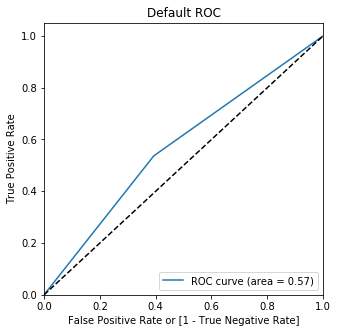

(array([0.        , 0.39307862, 1.        ]),
 array([0.        , 0.53654782, 1.        ]),
 array([2., 1., 0.]))

In [140]:
draw_roc(y_test, test_y_pred)

### Model building using demo and credit data

Master Data

In [2]:
demographic = pd.read_csv("Demographic data.csv", sep=",")
demographic.head()

,Application ID,Age,Gender,Marital Status (at the time of application),No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,Performance Tag
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000


In [3]:
credit_df = pd.read_csv("Credit Bureau data.csv", sep=",")
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71295 entries, 0 to 71294
Data columns (total 19 columns):
Application ID                                                     71295 non-null int64
No of times 90 DPD or worse in last 6 months                       71295 non-null int64
No of times 60 DPD or worse in last 6 months                       71295 non-null int64
No of times 30 DPD or worse in last 6 months                       71295 non-null int64
No of times 90 DPD or worse in last 12 months                      71295 non-null int64
No of times 60 DPD or worse in last 12 months                      71295 non-null int64
No of times 30 DPD or worse in last 12 months                      71295 non-null int64
Avgas CC Utilization in last 12 months                             70237 non-null float64
No of trades opened in last 6 months                               71294 non-null float64
No of trades opened in last 12 months                              71295 non-null int64
No of P

In [4]:
credit_df.columns = credit_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
credit_df.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,no_of_pl_trades_opened_in_last_12_months,no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans,no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans,presence_of_open_home_loan,outstanding_balance,total_no_of_trades,presence_of_open_auto_loan,performance_tag
0,954457215,0,0,0,0,0,0,4.000,1.000,2,0,0,0,0,1.000,2999395.000,4,0,0.000
1,432830445,0,0,0,0,0,0,3.000,1.000,2,0,0,0,0,0.000,3078.000,5,0,0.000
2,941387308,0,0,0,0,0,0,7.000,0.000,0,0,0,0,0,1.000,3004972.000,2,0,0.000
3,392161677,0,0,0,0,0,0,11.000,1.000,1,0,0,0,0,1.000,3355373.000,4,1,0.000
4,182011211,0,0,0,0,0,0,12.000,0.000,1,0,0,0,0,1.000,3014283.000,4,0,0.000


In [5]:
demographic.columns = demographic.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
demographic.head()

,application_id,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company,performance_tag
0,954457215,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56,0.000
1,432830445,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46,0.000
2,941387308,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49,0.000
3,392161677,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53,0.000
4,182011211,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43,0.000


In [6]:
master_df = pd.merge(credit_df, demographic, on='application_id')

In [7]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71301 entries, 0 to 71300
Data columns (total 30 columns):
application_id                                                   71301 non-null int64
no_of_times_90_dpd_or_worse_in_last_6_months                     71301 non-null int64
no_of_times_60_dpd_or_worse_in_last_6_months                     71301 non-null int64
no_of_times_30_dpd_or_worse_in_last_6_months                     71301 non-null int64
no_of_times_90_dpd_or_worse_in_last_12_months                    71301 non-null int64
no_of_times_60_dpd_or_worse_in_last_12_months                    71301 non-null int64
no_of_times_30_dpd_or_worse_in_last_12_months                    71301 non-null int64
avgas_cc_utilization_in_last_12_months                           70243 non-null float64
no_of_trades_opened_in_last_6_months                             71300 non-null float64
no_of_trades_opened_in_last_12_months                            71301 non-null int64
no_of_pl_trades_opened_in_l

In [8]:
master_df.isnull().sum()

application_id                                                      0
no_of_times_90_dpd_or_worse_in_last_6_months                        0
no_of_times_60_dpd_or_worse_in_last_6_months                        0
no_of_times_30_dpd_or_worse_in_last_6_months                        0
no_of_times_90_dpd_or_worse_in_last_12_months                       0
no_of_times_60_dpd_or_worse_in_last_12_months                       0
no_of_times_30_dpd_or_worse_in_last_12_months                       0
avgas_cc_utilization_in_last_12_months                           1058
no_of_trades_opened_in_last_6_months                                1
no_of_trades_opened_in_last_12_months                               0
no_of_pl_trades_opened_in_last_6_months                             0
no_of_pl_trades_opened_in_last_12_months                            0
no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans        0
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans       0
presence_of_open_hom

In [9]:
master_df = master_df.drop(['performance_tag_y'], 1)

In [10]:
master_df = master_df.rename(columns={'performance_tag_x': 'performance_tag'})

In [11]:
master_df.shape

(71301, 29)

In [12]:
# There are duplicate application_id in data frame
print(any(master_df['application_id'].duplicated())) 

True


In [13]:
# Dropping the duplicates keeping first
m = ~master_df['application_id'].duplicated(keep='first')
master_df=master_df[m]

In [14]:
master_df_copy=master_df.copy()
print(master_df.shape)

(71292, 29)


In [15]:
master_df_copy.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [16]:
master_df.columns

Index(['application_id', 'no_of_times_90_dpd_or_worse_in_last_6_months',
       'no_of_times_60_dpd_or_worse_in_last_6_months',
       'no_of_times_30_dpd_or_worse_in_last_6_months',
       'no_of_times_90_dpd_or_worse_in_last_12_months',
       'no_of_times_60_dpd_or_worse_in_last_12_months',
       'no_of_times_30_dpd_or_worse_in_last_12_months',
       'avgas_cc_utilization_in_last_12_months',
       'no_of_trades_opened_in_last_6_months',
       'no_of_trades_opened_in_last_12_months',
       'no_of_pl_trades_opened_in_last_6_months',
       'no_of_pl_trades_opened_in_last_12_months',
       'no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans',
       'no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans',
       'presence_of_open_home_loan', 'outstanding_balance',
       'total_no_of_trades', 'presence_of_open_auto_loan', 'performance_tag',
       'age', 'gender', 'marital_status_at_the_time_of_application',
       'no_of_dependents', 'income', 'education', 'pro

no_of_times_90_dpd_or_worse_in_last_6_months analysis

In [156]:
master_df['no_of_times_90_dpd_or_worse_in_last_6_months'].value_counts()

0    54867
1    13873
2     2258
3      294
Name: no_of_times_90_dpd_or_worse_in_last_6_months, dtype: int64

In [157]:
pd.crosstab(master_df.no_of_times_90_dpd_or_worse_in_last_6_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1)

performance_tag,0.0,1.0
no_of_times_90_dpd_or_worse_in_last_6_months,,
0,96.718,3.282
1,92.662,7.338
2,90.991,9.009
3,88.942,11.058


We can note that the number of 90 days dpd increase the default increase

no_of_times_60_dpd_or_worse_in_last_6_months

In [158]:
master_df['no_of_times_60_dpd_or_worse_in_last_6_months'].value_counts()

0    51922
1    11393
2     5412
3     1876
4      597
5       92
Name: no_of_times_60_dpd_or_worse_in_last_6_months, dtype: int64

In [159]:
tdata=pd.crosstab(master_df.no_of_times_60_dpd_or_worse_in_last_6_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1)

the number of defaults increses with number of miss payment in 60 days

no_of_times_30_dpd_or_worse_in_last_6_months

In [160]:
print(master_df['no_of_times_30_dpd_or_worse_in_last_6_months'].value_counts())

print(pd.crosstab(master_df.no_of_times_30_dpd_or_worse_in_last_6_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0    50108
1     9609
2     6194
3     3269
4     1389
5      565
6      142
7       16
Name: no_of_times_30_dpd_or_worse_in_last_6_months, dtype: int64
performance_tag                               0.000  1.000
no_of_times_30_dpd_or_worse_in_last_6_months              
0                                            97.096  2.904
1                                            93.453  6.547
2                                            92.098  7.902
3                                            91.343  8.657
4                                            89.761 10.239
5                                            88.860 11.140
6                                            91.667  8.333
7                                            93.333  6.667


no_of_times_90_dpd_or_worse_in_last_12_months

In [161]:
print(master_df['no_of_times_90_dpd_or_worse_in_last_12_months'].value_counts())

print(pd.crosstab(master_df.no_of_times_90_dpd_or_worse_in_last_12_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0    50539
1    11991
2     6654
3     1672
4      390
5       46
Name: no_of_times_90_dpd_or_worse_in_last_12_months, dtype: int64
performance_tag                                0.000  1.000
no_of_times_90_dpd_or_worse_in_last_12_months              
0                                             97.009  2.991
1                                             93.175  6.825
2                                             92.078  7.922
3                                             90.354  9.646
4                                             89.706 10.294
5                                             86.111 13.889


no_of_times_60_dpd_or_worse_in_last_12_months

In [162]:
print(master_df['no_of_times_60_dpd_or_worse_in_last_12_months'].value_counts())

print(pd.crosstab(master_df.no_of_times_60_dpd_or_worse_in_last_12_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0    45880
1    12927
2     6695
3     3643
4     1420
5      569
6      148
7       10
Name: no_of_times_60_dpd_or_worse_in_last_12_months, dtype: int64
performance_tag                                 0.000  1.000
no_of_times_60_dpd_or_worse_in_last_12_months               
0                                              96.996  3.004
1                                              94.827  5.173
2                                              92.485  7.515
3                                              91.451  8.549
4                                              90.363  9.637
5                                              90.955  9.045
6                                              88.288 11.712
7                                             100.000  0.000


no_of_times_30_dpd_or_worse_in_last_12_months

In [163]:
print(master_df['no_of_times_30_dpd_or_worse_in_last_12_months'].value_counts())

print(pd.crosstab(master_df.no_of_times_30_dpd_or_worse_in_last_12_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0    44862
1    11502
2     6265
3     4450
4     2309
5     1166
6      549
7      160
8       27
9        2
Name: no_of_times_30_dpd_or_worse_in_last_12_months, dtype: int64
performance_tag                                 0.000  1.000
no_of_times_30_dpd_or_worse_in_last_12_months               
0                                              97.066  2.934
1                                              95.485  4.515
2                                              92.626  7.374
3                                              91.562  8.438
4                                              91.008  8.992
5                                              89.566 10.434
6                                              89.894 10.106
7                                              89.720 10.280
8                                              91.304  8.696
9                                             100.000  0.000


avgas_cc_utilization_in_last_12_months

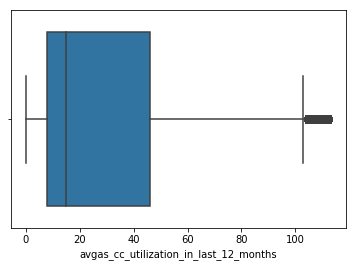

In [164]:
sns.boxplot(x='avgas_cc_utilization_in_last_12_months', data=master_df)
plt.show()

no_of_trades_opened_in_last_6_months

In [165]:
print(master_df['no_of_trades_opened_in_last_6_months'].value_counts())

print(pd.crosstab(master_df.no_of_trades_opened_in_last_6_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

1.000     20250
2.000     12461
0.000     12231
3.000      9850
4.000      6624
5.000      3791
6.000      2349
7.000      1649
8.000      1154
9.000       618
10.000      238
11.000       65
12.000       11
Name: no_of_trades_opened_in_last_6_months, dtype: int64
performance_tag                        0.000  1.000
no_of_trades_opened_in_last_6_months               
0.000                                 97.769  2.231
1.000                                 97.346  2.654
2.000                                 94.734  5.266
3.000                                 93.629  6.371
4.000                                 93.076  6.924
5.000                                 94.216  5.784
6.000                                 95.334  4.666
7.000                                 96.058  3.942
8.000                                 95.494  4.506
9.000                                 96.602  3.398
10.000                                97.059  2.941
11.000                                96.923  3.077
12.000 

no_of_trades_opened_in_last_12_months

In [166]:
print(master_df['no_of_trades_opened_in_last_12_months'].value_counts())

print(pd.crosstab(master_df.no_of_trades_opened_in_last_12_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

1     11380
2      9342
0      4957
4      4925
3      4712
5      4657
6      4391
7      4302
8      3995
9      3573
10     2994
11     2293
12     1762
13     1406
14     1124
15     1068
16      992
17      860
18      736
19      612
20      434
21      308
22      218
23      121
24       73
25       34
26       11
27        9
28        3
Name: no_of_trades_opened_in_last_12_months, dtype: int64
performance_tag                         0.000  1.000
no_of_trades_opened_in_last_12_months               
0                                      97.760  2.240
1                                      98.435  1.565
2                                      98.091  1.909
3                                      95.767  4.233
4                                      95.711  4.289
5                                      94.898  5.102
6                                      93.653  6.347
7                                      93.447  6.553
8                                      91.972  8.028
9          

no_of_pl_trades_opened_in_last_6_months

In [167]:
print(master_df['no_of_pl_trades_opened_in_last_6_months'].value_counts())

print(pd.crosstab(master_df.no_of_pl_trades_opened_in_last_6_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0    31193
1    13852
2    13079
3     8320
4     3462
5     1090
6      296
Name: no_of_pl_trades_opened_in_last_6_months, dtype: int64
performance_tag                          0.000  1.000
no_of_pl_trades_opened_in_last_6_months              
0                                       97.751  2.249
1                                       94.899  5.101
2                                       93.609  6.391
3                                       93.697  6.303
4                                       94.104  5.896
5                                       95.596  4.404
6                                       97.297  2.703


no_of_pl_trades_opened_in_last_12_months

In [168]:
print(master_df['no_of_pl_trades_opened_in_last_12_months'].value_counts())

print(pd.crosstab(master_df.no_of_pl_trades_opened_in_last_12_months, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0     25828
3      8432
4      8272
2      6982
1      6693
5      6485
6      4206
7      2284
8      1178
9       601
10      255
11       66
12       10
Name: no_of_pl_trades_opened_in_last_12_months, dtype: int64
performance_tag                           0.000  1.000
no_of_pl_trades_opened_in_last_12_months              
0                                        98.230  1.770
1                                        96.281  3.719
2                                        94.641  5.359
3                                        93.764  6.236
4                                        93.230  6.770
5                                        93.682  6.318
6                                        93.960  6.040
7                                        95.097  4.903
8                                        95.734  4.266
9                                        95.341  4.659
10                                       96.078  3.922
11                                       95.455  4.545
12           

no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans

In [169]:
print(master_df['no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans'].value_counts())

print(pd.crosstab(master_df['no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans'], master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0     25176
1     13511
2     13349
3      7585
4      4385
5      3019
6      1750
7      1149
8       835
9       425
10      108
Name: no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans, dtype: int64
performance_tag                                     0.000  1.000
no_of_inquiries_in_last_6_months_excluding_home...              
0                                                  97.898  2.102
1                                                  95.006  4.994
2                                                  94.817  5.183
3                                                  92.877  7.123
4                                                  93.668  6.332
5                                                  95.031  4.969
6                                                  95.829  4.171
7                                                  96.519  3.481
8                                                  96.048  3.952
9                                                  96.941  3.059
10     

no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans

In [170]:
print(master_df['no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans'].value_counts())

print(pd.crosstab(master_df['no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans'], master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0     20593
3      9281
2      8075
4      7491
5      5234
1      3932
6      3766
7      3054
8      2355
9      1777
10     1508
11     1231
12      936
13      789
14      553
15      360
16      212
17       97
18       40
19        6
20        2
Name: no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans, dtype: int64
performance_tag                                      0.000  1.000
no_of_inquiries_in_last_12_months_excluding_hom...               
0                                                   98.508  1.492
1                                                   96.025  3.975
2                                                   95.169  4.831
3                                                   95.066  4.934
4                                                   94.658  5.342
5                                                   92.653  7.347
6                                                   93.165  6.835
7                                                   93.015  6.985
8     

presence_of_open_home_loan

In [171]:
print(master_df['presence_of_open_home_loan'].value_counts())

print(pd.crosstab(master_df.presence_of_open_home_loan, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0.000    52808
1.000    18212
Name: presence_of_open_home_loan, dtype: int64
performance_tag             0.000  1.000
presence_of_open_home_loan              
0.000                      95.474  4.526
1.000                      96.641  3.359


outstanding_balance

In [172]:
print(master_df['outstanding_balance'].value_counts())

#print(pd.crosstab(master_df.outstanding_balance, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0.000          809
2595.000         6
3528.000         6
4295.000         6
2577.000         6
2773.000         6
2918.000         5
7714.000         5
1528.000         5
77.000           5
11005.000        5
5729.000         5
1228.000         5
716.000          5
5571.000         5
5.000            5
4017.000         5
4569.000         5
3305.000         5
1302.000         5
9314.000         5
713.000          5
1494.000         5
5092.000         4
98.000           4
9430.000         4
6482.000         4
2876.000         4
1754.000         4
1477.000         4
              ... 
2952510.000      1
2952512.000      1
1476261.000      1
2952524.000      1
3141187.000      1
769626.000       1
4441519.000      1
2952655.000      1
1738469.000      1
2952647.000      1
738160.000       1
1000303.000      1
607085.000       1
3344014.000      1
558579.000       1
607079.000       1
2952601.000      1
2952598.000      1
2952592.000      1
3125241.000      1
1214142.000      1
2952571.000 

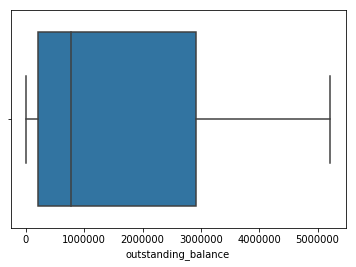

In [173]:
sns.boxplot(x='outstanding_balance', data=master_df)
plt.show()

total_no_of_trades

In [174]:
print(pd.crosstab(master_df.total_no_of_trades, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

performance_tag      0.000  1.000
total_no_of_trades               
0                   95.749  4.251
1                   98.496  1.504
2                   98.433  1.567
3                   97.864  2.136
4                   97.263  2.737
5                   95.975  4.025
6                   95.228  4.772
7                   94.408  5.592
8                   93.470  6.530
9                   92.780  7.220
10                  93.152  6.848
11                  93.488  6.512
12                  92.245  7.755
13                  92.247  7.753
14                  92.275  7.725
15                  94.292  5.708
16                  95.833  4.167
17                  97.475  2.525
18                  96.614  3.386
19                  96.840  3.160
20                  96.091  3.909
21                  96.870  3.130
22                  96.392  3.608
23                  95.845  4.155
24                  95.359  4.641
25                  96.575  3.425
26                  95.305  4.695
27            

presence_of_open_auto_loan

In [175]:
print(master_df['presence_of_open_auto_loan'].value_counts())

print(pd.crosstab(master_df.presence_of_open_auto_loan, master_df.performance_tag).apply(lambda r: r/r.sum()*100, axis=1))

0    65259
1     6033
Name: presence_of_open_auto_loan, dtype: int64
performance_tag             0.000  1.000
presence_of_open_auto_loan              
0                          95.733  4.267
1                          96.307  3.693


In [176]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

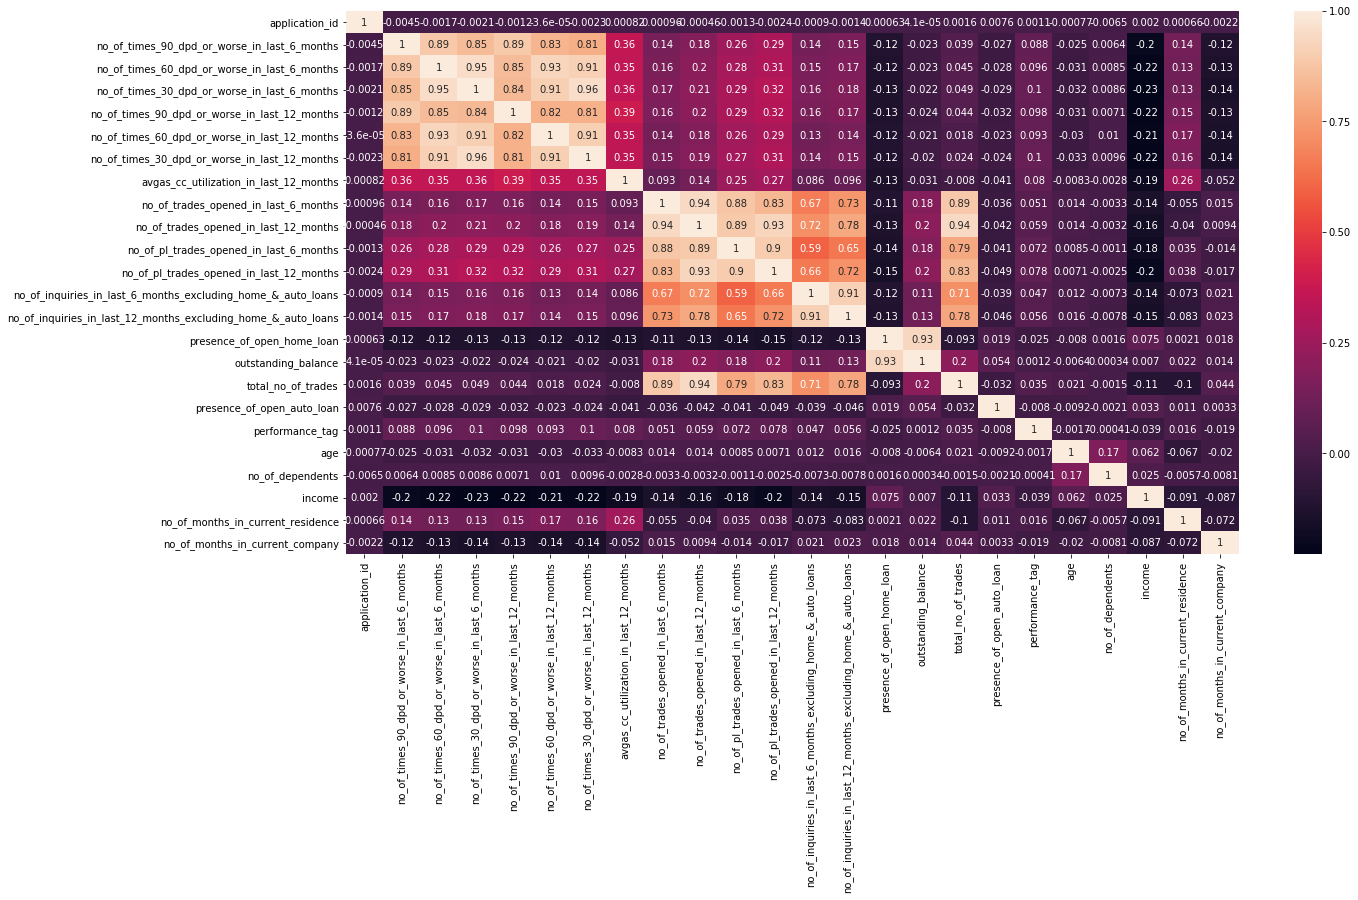

In [177]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(master_df.corr(),annot = True)
plt.show()

### Data prepartion

In [18]:
master_df=master_df_copy.copy()

In [19]:
master_df.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [20]:
# All performance tag null to one data frmae
master_df_null=master_df[master_df.performance_tag.isnull()]

In [21]:
print(master_df_null.shape)
master_df_null.head()

(1425, 29)


,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
69609,906908303,0,0,2,1,2,3,30.000,4.000,12,...,35,M,Single,1.000,6.000,Bachelor,SAL,Rented,22,18
69610,10990583,1,1,1,3,2,2,16.000,3.000,7,...,47,F,Married,4.000,12.000,Masters,SE,Rented,122,25
69611,589678446,3,4,5,3,5,6,83.000,2.000,7,...,46,M,Married,3.000,7.000,Professional,SE,Rented,10,31
69612,809411322,1,3,4,3,4,5,87.000,2.000,7,...,41,M,Married,3.000,18.000,Masters,SAL,Rented,6,47
69613,150246616,2,2,4,3,2,6,42.000,3.000,7,...,42,F,Married,4.000,17.000,Phd,SAL,Rented,8,49


In [22]:
# Performance tag not null to one column
master_df_performance=master_df[master_df.performance_tag.notnull()]

In [23]:
master_df_performance.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [24]:
master_df_performance.shape

(69867, 29)

In [25]:
# Keeping the unsamples data for later class imbalance
master_df_performance_unsampled=master_df_performance.copy()
master_df_performance_unsampled.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [33]:
# Checking null
master_df_performance_unsampled.isnull().sum()

application_id                                                     0
no_of_times_90_dpd_or_worse_in_last_6_months                       0
no_of_times_60_dpd_or_worse_in_last_6_months                       0
no_of_times_30_dpd_or_worse_in_last_6_months                       0
no_of_times_90_dpd_or_worse_in_last_12_months                      0
no_of_times_60_dpd_or_worse_in_last_12_months                      0
no_of_times_30_dpd_or_worse_in_last_12_months                      0
avgas_cc_utilization_in_last_12_months                             0
no_of_trades_opened_in_last_6_months                               0
no_of_trades_opened_in_last_12_months                              0
no_of_pl_trades_opened_in_last_6_months                            0
no_of_pl_trades_opened_in_last_12_months                           0
no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans       0
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans      0
presence_of_open_home_loan        

In [27]:
# avgas_cc_utilization_in_last_12_months has null value replace with 0
master_df_performance_unsampled.avgas_cc_utilization_in_last_12_months.fillna(0, inplace=True)

In [32]:
# no_of_trades_opened_in_last_6_months has 1 na removing it
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.no_of_trades_opened_in_last_6_months.notnull()]

In [34]:
# gender has 2 na remove it
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.gender.notnull()]

In [35]:
# marital_status_at_the_time_of_application has 6 na removing it
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.marital_status_at_the_time_of_application.notnull()]

In [36]:
# no_of_dependents has 3 na removing it
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.no_of_dependents.notnull()]

In [37]:
# type_of_residence has 3 na removing it
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.type_of_residence.notnull()]

In [38]:
# profession has 3 na removing it
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.profession.notnull()]

In [39]:
# presence_of_open_home_loan has 3 na removing it
master_df_performance_unsampled[['presence_of_open_home_loan','avgas_cc_utilization_in_last_12_months','outstanding_balance']][master_df_performance_unsampled.presence_of_open_home_loan.isnull()].head()

,presence_of_open_home_loan,avgas_cc_utilization_in_last_12_months,outstanding_balance
10512,nan,0.000,nan
10563,nan,0.000,nan
10586,nan,0.000,nan
10597,nan,0.000,nan
10766,nan,0.000,nan


presence_of_open_home_loan, avgas_cc_utilization_in_last_12_months and outstanding_balance are null and zero so removing these cilumnnbsd


In [40]:
master_df_performance_unsampled=master_df_performance_unsampled[master_df_performance_unsampled.presence_of_open_home_loan.notnull()]

In [41]:
# education has 117 na value replace it with the major value
master_df_performance_unsampled.education.fillna('unkown', inplace=True)

In [42]:
# negative income replace with 0
master_df_performance_unsampled['income'][master_df_performance_unsampled['income'] < 0] = 0

In [43]:
master_df_performance_unsampled.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [44]:
master_df_performance_unsampled_cleaned=master_df_performance_unsampled.copy()

In [200]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [201]:
master_df_notnull_woe = master_df_performance_unsampled.drop(['application_id'], axis=1)

In [202]:
master_df_notnull_woe.head()

,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,0,0,0,0,0,0,4.000,1.000,2,0,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,0,0,0,0,0,0,3.000,1.000,2,0,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,0,0,0,0,0,0,7.000,0.000,0,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,0,0,0,0,0,0,11.000,1.000,1,0,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,0,0,0,0,0,0,12.000,0.000,1,0,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [203]:
iv, woe = iv_woe(data = master_df_notnull_woe, target = 'performance_tag', bins=10, show_woe = False)
#print(woe)

In [204]:
# print Information value
df = pd.DataFrame(columns=['Feature name', 'Information value', 'strength'])
i=0;
for index,row in iv.iterrows():
    strength='Not useful';
    if(row['IV']>=.02 and row['IV']<.1):
        strength='Weak';
    elif(row['IV']>=.1 and row['IV']<.3):
        strength='Medium';
    elif(row['IV']>=.3 and row['IV']<=.5):
        strength=' Strong';
    elif(row['IV']>.5):
        strength='Suspicious';
    #print(row['Variable'],row['IV'],strength)
    df.loc[i] = [row['Variable'],row['IV'],strength]
    i=i+1;
df.sort_values('Information value',ascending=False)

,Feature name,Information value,strength
6,avgas_cc_utilization_in_last_12_months,0.301,Strong
8,no_of_trades_opened_in_last_12_months,0.295,Medium
10,no_of_pl_trades_opened_in_last_12_months,0.259,Medium
14,outstanding_balance,0.247,Medium
12,no_of_inquiries_in_last_12_months_excluding_ho...,0.246,Medium
2,no_of_times_30_dpd_or_worse_in_last_6_months,0.245,Medium
15,total_no_of_trades,0.234,Medium
9,no_of_pl_trades_opened_in_last_6_months,0.225,Medium
5,no_of_times_30_dpd_or_worse_in_last_12_months,0.219,Medium
3,no_of_times_90_dpd_or_worse_in_last_12_months,0.216,Medium


In [205]:
# Getting the predictive columns
pred_columns=list(iv[(iv['IV']>=.1) & (iv['IV']<=.5)]['Variable'])
pred_columns

['no_of_times_90_dpd_or_worse_in_last_6_months',
 'no_of_times_60_dpd_or_worse_in_last_6_months',
 'no_of_times_30_dpd_or_worse_in_last_6_months',
 'no_of_times_90_dpd_or_worse_in_last_12_months',
 'no_of_times_60_dpd_or_worse_in_last_12_months',
 'no_of_times_30_dpd_or_worse_in_last_12_months',
 'avgas_cc_utilization_in_last_12_months',
 'no_of_trades_opened_in_last_6_months',
 'no_of_trades_opened_in_last_12_months',
 'no_of_pl_trades_opened_in_last_6_months',
 'no_of_pl_trades_opened_in_last_12_months',
 'no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans',
 'no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans',
 'outstanding_balance',
 'total_no_of_trades']

In [206]:
woe.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,no_of_times_90_dpd_or_worse_in_last_6_months,0,54371,1786.000,0.608,52585.000,0.789,-0.261,0.047
1,no_of_times_90_dpd_or_worse_in_last_6_months,1,13211,970.000,0.330,12241.000,0.184,0.586,0.086
2,no_of_times_90_dpd_or_worse_in_last_6_months,2,1773,160.000,0.054,1613.000,0.024,0.810,0.024
3,no_of_times_90_dpd_or_worse_in_last_6_months,3,208,23.000,0.008,185.000,0.003,1.036,0.005
0,no_of_times_60_dpd_or_worse_in_last_6_months,0,51578,1574.000,0.536,50004.000,0.751,-0.337,0.073


In [207]:
for str in pred_columns:
    print(str)
    master_df_performance_unsampled[str] = master_df_performance_unsampled.apply(lambda row : woe_replace(row[str], 
                                  str), axis = 1) 

no_of_times_90_dpd_or_worse_in_last_6_months
no_of_times_60_dpd_or_worse_in_last_6_months
no_of_times_30_dpd_or_worse_in_last_6_months
no_of_times_90_dpd_or_worse_in_last_12_months
no_of_times_60_dpd_or_worse_in_last_12_months
no_of_times_30_dpd_or_worse_in_last_12_months
avgas_cc_utilization_in_last_12_months
no_of_trades_opened_in_last_6_months
no_of_trades_opened_in_last_12_months
no_of_pl_trades_opened_in_last_6_months
no_of_pl_trades_opened_in_last_12_months
no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans
outstanding_balance


KeyboardInterrupt: 

In [208]:
pred_columns.append('performance_tag')
pred_columns

['no_of_times_90_dpd_or_worse_in_last_6_months',
 'no_of_times_60_dpd_or_worse_in_last_6_months',
 'no_of_times_30_dpd_or_worse_in_last_6_months',
 'no_of_times_90_dpd_or_worse_in_last_12_months',
 'no_of_times_60_dpd_or_worse_in_last_12_months',
 'no_of_times_30_dpd_or_worse_in_last_12_months',
 'avgas_cc_utilization_in_last_12_months',
 'no_of_trades_opened_in_last_6_months',
 'no_of_trades_opened_in_last_12_months',
 'no_of_pl_trades_opened_in_last_6_months',
 'no_of_pl_trades_opened_in_last_12_months',
 'no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans',
 'no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans',
 'outstanding_balance',
 'total_no_of_trades',
 'performance_tag']

In [209]:
master_df_performance_unsampled.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.780,-0.546,-0.907,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.618,-0.546,-0.907,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.469,-0.546,-0.907,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [210]:
master_df_performance_unsampled_woe=master_df_performance_unsampled.copy()

In [211]:
master_df_performance_unsampled.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.780,-0.546,-0.907,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.618,-0.546,-0.907,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.469,-0.546,-0.907,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


### Model Building imbalance data

In [212]:
master_df_model_unsampled=master_df_performance_unsampled[pred_columns]

In [213]:
# Import library to split the dataset into test and train

from sklearn.model_selection import train_test_split

In [214]:
# Putting feature variable to X
X = master_df_model_unsampled.drop(['performance_tag'],axis=1)

# Putting response variable to y
y = master_df_model_unsampled['performance_tag']

In [215]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

LogisticRegression Model Building with master data frame

In [216]:
# Fitting the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [217]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        performance_tag   No. Observations:                48694
Model:                            GLM   Df Residuals:                    48678
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8285.6
Date:                Sat, 14 Sep 2019   Deviance:                       16571.
Time:                        21:32:26   Pearson chi2:                 4.83e+04
No. Iterations:                     7   Covariance Type:             nonrobust
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                            -3.1547      0.051    -61.881      0.000      -3.255      -3.055
no_of_times_90_dpd_or_worse_in_last_6_months                     -0.0685      0.126     -0.542      0.588      -0.316       0.179
no_of_times_60_dpd_or_worse_in_last_6_months                     -0.0858      0.173     -0.495      0.620      -0.425       0.254
no_of_times_30_dpd_or_worse_in_last_6_months                      0.3870      0.168      2.303      0.021       0.058       0.716
no_of_times_90_dpd_or_worse_in_last_12_months                     0.0633      0.105      0.603      0.547      -0.142       0.269
no_of_times_60_dpd_or_worse_in_last_12_months                    -0.0644      0.132     -0.487      0.626      -0.324       0.195
no_of_times_30_dpd_or_worse_in_last_12_months                     0.1840      0.135      1.366      0.172      -0.080       0.448
avgas_cc_utilization_in_last_12_months                            0.4126      0.067      6.164      0.000       0.281       0.544
no_of_trades_opened_in_last_6_months                             -0.1017      0.098     -1.033      0.302      -0.295       0.091
no_of_trades_opened_in_last_12_months                             0.2794      0.112      2.485      0.013       0.059       0.500
no_of_pl_trades_opened_in_last_6_months                           0.0693      0.105      0.657      0.511      -0.137       0.276
no_of_pl_trades_opened_in_last_12_months                         -0.0341      0.101     -0.336      0.737      -0.233       0.165
no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans     -0.0052      0.085     -0.061      0.951      -0.172       0.161
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans     0.2981      0.079      3.786      0.000       0.144       0.452
outstanding_balance                                           -4.835e-09   1.93e-08     -0.251      0.802   -4.26e-08    3.29e-08
total_no_of_trades                                                0.0074      0.005      1.571      0.116      -0.002       0.017
=================================================================================================================================
"""

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train, y=y_train)

test_y_pred = logisticRegr.predict(X_test)
accuracy =  metrics.accuracy_score(y_test, test_y_pred)
print("accuracy:", accuracy)
print(classification_report(y_test, test_y_pred))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test, y_pred=test_y_pred)
print(cmlr)

accuracy: 0.959700991901864
             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     20028
        1.0       0.00      0.00      0.00       841

avg / total       0.92      0.96      0.94     20869

[[20028     0]
 [  841     0]]


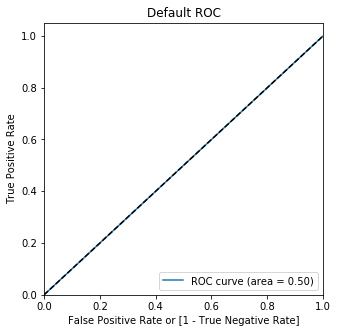

(array([0., 1.]), array([0., 1.]), array([1., 0.]))

In [219]:
# Roc Curv
draw_roc(y_test, test_y_pred)

### Model Building using Over sample data

### Over-sampling the minority class

This will create synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class.

In [220]:
master_df_performance_woe=master_df_performance_unsampled_woe.copy()

In [221]:
master_df_performance_unsampled['performance_tag'].value_counts()

0.000    66624
1.000     2939
Name: performance_tag, dtype: int64

In [222]:
from sklearn.utils import resample

master_df_majority = master_df_performance_unsampled[master_df_performance_unsampled['performance_tag']==0]
master_df_minority = master_df_performance_unsampled[master_df_performance_unsampled['performance_tag']==1]

master_df_minority_upsampled = resample(master_df_minority,
replace=True,
n_samples=66624, #same number of samples as majority class
random_state=1) #set the seed for random resampling
# Combine resampled results
master_df_performance_sampled = pd.concat([master_df_majority, master_df_minority_upsampled])

master_df_performance_sampled['performance_tag'].value_counts()

1.000    66624
0.000    66624
Name: performance_tag, dtype: int64

In [223]:
master_df_model=master_df_performance_sampled[pred_columns]

In [224]:
master_df_model.shape

(133248, 16)

In [225]:
master_df_model.head()

,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,no_of_pl_trades_opened_in_last_12_months,no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans,no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans,outstanding_balance,total_no_of_trades,performance_tag
0,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,-0.653,-0.691,-0.320,-0.833,2999395.000,4,0.000
1,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,-0.653,-0.691,-0.320,-0.833,3078.000,5,0.000
2,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.780,-0.546,-0.907,-0.653,-0.691,-0.320,-0.833,3004972.000,2,0.000
3,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.618,-0.546,-0.907,-0.653,-0.691,-0.320,-0.833,3355373.000,4,0.000
4,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.469,-0.546,-0.907,-0.653,-0.691,-0.320,-0.833,3014283.000,4,0.000


In [226]:
# Import library to split the dataset into test and train

from sklearn.model_selection import train_test_split

In [227]:
# Putting feature variable to X
X = master_df_model.drop(['performance_tag'],axis=1)

# Putting response variable to y
y = master_df_model['performance_tag']

In [228]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [229]:
X_train.head()

,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,no_of_pl_trades_opened_in_last_12_months,no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans,no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans,outstanding_balance,total_no_of_trades
1408,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.780,-0.546,-0.818,-0.653,-0.691,-0.320,-0.833,2987500.000,3
41722,0.586,0.540,0.463,0.508,0.213,0.591,0.360,-0.546,-0.818,-0.653,-0.691,-0.320,0.138,204046.000,3
6822,-0.261,-0.337,-0.388,-0.358,0.213,0.070,-0.780,-0.546,-0.818,-0.653,-0.691,-0.320,-0.833,22840.000,4
62604,0.586,0.668,0.666,0.669,0.611,0.737,0.567,0.332,0.403,0.423,0.378,0.214,0.587,1259137.000,13
27508,-0.261,-0.337,-0.388,-0.358,-0.353,-0.378,-0.716,-0.546,-0.818,-0.653,-0.691,-0.320,0.138,19491.000,4


### LogisticRegression Model Building with master data frame

In [230]:
# Fitting the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [231]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        performance_tag   No. Observations:                93273
Model:                            GLM   Df Residuals:                    93257
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60034.
Date:                Sat, 14 Sep 2019   Deviance:                   1.2007e+05
Time:                        21:32:29   Pearson chi2:                 9.32e+04
No. Iterations:                     5   Covariance Type:             nonrobust
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                            -0.0293      0.015     -1.945      0.052      -0.059       0.000
no_of_times_90_dpd_or_worse_in_last_6_months                     -0.1699      0.044     -3.868      0.000      -0.256      -0.084
no_of_times_60_dpd_or_worse_in_last_6_months                      0.0556      0.059      0.946      0.344      -0.060       0.171
no_of_times_30_dpd_or_worse_in_last_6_months                      0.3075      0.057      5.425      0.000       0.196       0.419
no_of_times_90_dpd_or_worse_in_last_12_months                     0.1602      0.033      4.789      0.000       0.095       0.226
no_of_times_60_dpd_or_worse_in_last_12_months                    -0.1001      0.042     -2.395      0.017      -0.182      -0.018
no_of_times_30_dpd_or_worse_in_last_12_months                     0.1445      0.044      3.276      0.001       0.058       0.231
avgas_cc_utilization_in_last_12_months                            0.4330      0.019     22.634      0.000       0.396       0.471
no_of_trades_opened_in_last_6_months                             -0.0645      0.030     -2.132      0.033      -0.124      -0.005
no_of_trades_opened_in_last_12_months                             0.2365      0.033      7.266      0.000       0.173       0.300
no_of_pl_trades_opened_in_last_6_months                           0.0355      0.032      1.098      0.272      -0.028       0.099
no_of_pl_trades_opened_in_last_12_months                          0.0738      0.031      2.417      0.016       0.014       0.134
no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans     -0.0430      0.027     -1.598      0.110      -0.096       0.010
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans     0.3371      0.022     15.079      0.000       0.293       0.381
outstanding_balance                                            -1.59e-08   5.72e-09     -2.780      0.005   -2.71e-08   -4.69e-09
total_no_of_trades                                                0.0046      0.001      3.280      0.001       0.002       0.007
=================================================================================================================================
"""

In [232]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train, y=y_train)

test_y_pred = logisticRegr.predict(X_test)
accuracy =  metrics.accuracy_score(y_test, test_y_pred)
print("accuracy:", accuracy)
print(classification_report(y_test, test_y_pred))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test, y_pred=test_y_pred)
print(cmlr)

accuracy: 0.6311694809255785
             precision    recall  f1-score   support

        0.0       0.63      0.64      0.64     19903
        1.0       0.64      0.62      0.63     20072

avg / total       0.63      0.63      0.63     39975

[[12826  7077]
 [ 7667 12405]]


Uisng RFE

In [233]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [234]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [235]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('no_of_times_90_dpd_or_worse_in_last_6_months', True, 1),
 ('no_of_times_60_dpd_or_worse_in_last_6_months', True, 1),
 ('no_of_times_30_dpd_or_worse_in_last_6_months', True, 1),
 ('no_of_times_90_dpd_or_worse_in_last_12_months', True, 1),
 ('no_of_times_60_dpd_or_worse_in_last_12_months', True, 1),
 ('no_of_times_30_dpd_or_worse_in_last_12_months', True, 1),
 ('avgas_cc_utilization_in_last_12_months', True, 1),
 ('no_of_trades_opened_in_last_6_months', False, 2),
 ('no_of_trades_opened_in_last_12_months', True, 1),
 ('no_of_pl_trades_opened_in_last_6_months', False, 3),
 ('no_of_pl_trades_opened_in_last_12_months', True, 1),
 ('no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans', False, 4),
 ('no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans', True, 1),
 ('outstanding_balance', False, 6),
 ('total_no_of_trades', False, 5)]

In [236]:
col = X_train.columns[rfe.support_]
col

Index(['no_of_times_90_dpd_or_worse_in_last_6_months',
       'no_of_times_60_dpd_or_worse_in_last_6_months',
       'no_of_times_30_dpd_or_worse_in_last_6_months',
       'no_of_times_90_dpd_or_worse_in_last_12_months',
       'no_of_times_60_dpd_or_worse_in_last_12_months',
       'no_of_times_30_dpd_or_worse_in_last_12_months',
       'avgas_cc_utilization_in_last_12_months',
       'no_of_trades_opened_in_last_12_months',
       'no_of_pl_trades_opened_in_last_12_months',
       'no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans'],
      dtype='object')

In [237]:
X_train.columns[~rfe.support_]

Index(['no_of_trades_opened_in_last_6_months',
       'no_of_pl_trades_opened_in_last_6_months',
       'no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans',
       'outstanding_balance', 'total_no_of_trades'],
      dtype='object')

In [238]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [239]:
X_test_rfe = X_test[col]

In [240]:
# Fitting the model
logreg = LogisticRegression()
logreg.fit(X_train_rfe, y_train)
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        performance_tag   No. Observations:                93273
Model:                            GLM   Df Residuals:                    93262
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60045.
Date:                Sat, 14 Sep 2019   Deviance:                   1.2009e+05
Time:                        21:32:32   Pearson chi2:                 9.32e+04
No. Iterations:                     5   Covariance Type:             nonrobust
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                            -0.0082      0.007     -1.190      0.234      -0.022       0.005
no_of_times_90_dpd_or_worse_in_last_6_months                     -0.1571      0.044     -3.589      0.000      -0.243      -0.071
no_of_times_60_dpd_or_worse_in_last_6_months                      0.0647      0.059      1.103      0.270      -0.050       0.180
no_of_times_30_dpd_or_worse_in_last_6_months                      0.2952      0.057      5.216      0.000       0.184       0.406
no_of_times_90_dpd_or_worse_in_last_12_months                     0.1482      0.033      4.456      0.000       0.083       0.213
no_of_times_60_dpd_or_worse_in_last_12_months                    -0.1120      0.042     -2.686      0.007      -0.194      -0.030
no_of_times_30_dpd_or_worse_in_last_12_months                     0.1345      0.044      3.056      0.002       0.048       0.221
avgas_cc_utilization_in_last_12_months                            0.4249      0.018     23.268      0.000       0.389       0.461
no_of_trades_opened_in_last_12_months                             0.2112      0.027      7.951      0.000       0.159       0.263
no_of_pl_trades_opened_in_last_12_months                          0.1170      0.026      4.550      0.000       0.067       0.167
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans     0.3380      0.019     17.648      0.000       0.300       0.376
=================================================================================================================================
"""

In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train_rfe, y=y_train)

test_y_pred = logisticRegr.predict(X_test_rfe)
accuracy =  metrics.accuracy_score(y_test, test_y_pred)
print("accuracy:", accuracy)
print(classification_report(y_test, test_y_pred))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test, y_pred=test_y_pred)
print(cmlr)

accuracy: 0.6393245778611633
             precision    recall  f1-score   support

        0.0       0.65      0.60      0.63     19903
        1.0       0.63      0.67      0.65     20072

avg / total       0.64      0.64      0.64     39975

[[12019  7884]
 [ 6534 13538]]


In [114]:
draw_roc(y_test, test_y_pred)

NameError: name 'test_y_pred' is not defined

Using over sampled data we got the performance of 63% lets try building model using other complex model

####  Decision Tree Classifier

In [242]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [243]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

             precision    recall  f1-score   support

        0.0       0.68      0.55      0.61     19903
        1.0       0.63      0.74      0.68     20072

avg / total       0.65      0.65      0.64     39975



In [244]:
# Printing confusion matrix
print(confusion_matrix(y_test,y_pred_default))

[[11046  8857]
 [ 5217 14855]]


Now we will try to tune the hyperparameters

- Maximum Depth
- Minimum Samples Leaf
- Minimum Samples Split
- Criterion

We will use gridsearchCV to tune the hyperparameters

In [245]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   33.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [246]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.295,0.026,0.009,0.003,entropy,5,50,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.643,...,0.643,0.003,11,0.645,0.647,0.642,0.645,0.644,0.645,0.002
1,0.290,0.014,0.007,0.002,entropy,5,50,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.643,...,0.643,0.003,11,0.645,0.647,0.642,0.645,0.644,0.645,0.002
2,0.296,0.020,0.007,0.001,entropy,5,100,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.643,...,0.642,0.002,15,0.644,0.647,0.642,0.645,0.642,0.644,0.002
3,0.332,0.036,0.007,0.001,entropy,5,100,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.643,...,0.642,0.002,15,0.644,0.647,0.642,0.645,0.642,0.644,0.002
4,0.466,0.042,0.008,0.002,entropy,10,50,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.673,...,0.670,0.004,4,0.681,0.678,0.673,0.684,0.678,0.679,0.004
5,0.454,0.026,0.009,0.002,entropy,10,50,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.673,...,0.670,0.004,3,0.681,0.678,0.673,0.684,0.678,0.679,0.004
6,0.524,0.099,0.009,0.001,entropy,10,100,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.675,...,0.667,0.005,6,0.677,0.674,0.670,0.681,0.676,0.676,0.004
7,0.472,0.025,0.010,0.003,entropy,10,100,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.675,...,0.668,0.005,5,0.677,0.674,0.670,0.681,0.677,0.676,0.004
8,0.238,0.032,0.007,0.002,gini,5,50,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.641,...,0.643,0.003,9,0.646,0.648,0.643,0.647,0.644,0.646,0.002
9,0.257,0.026,0.010,0.004,gini,5,50,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.641,...,0.643,0.003,10,0.646,0.648,0.643,0.647,0.644,0.646,0.002


In [247]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.6719736686929765
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Now we will create a model with the parameters found with best accuracy

- min_samples_leaf = 50
- min-Samples_aplit = 50
- max_depth = 5
- criterion = entropy

In [248]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = None,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [249]:
# accuracy score
clf_gini.score(X_test,y_test)

0.678499061913696

Decision Tree Classifier we got the performance of 67% that is better than LR 63%

Now that we have looked at Logistic Regression and Decision trees, we will look at Ensemble model that is Random Forest

#### Random Forest

In [250]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [251]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [252]:
# fit model
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [253]:
y_pred = rfc.predict(X_test)

In [254]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99     19903
        1.0       0.97      1.00      0.99     20072

avg / total       0.99      0.99      0.99     39975



In [255]:
# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[19381   522]
 [   18 20054]]


In [256]:
print(accuracy_score(y_test,y_pred))

0.9864915572232645


Once again, we are going to tune the hyperparameters

- Number of trees (estimators)
- Maximum Depth
- Minimum Samples leaf
- Minimum Samples Split
- Maximum features

In [257]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [258]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 79.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 83.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 8, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [100, 200, 300], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [259]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.6765194643680379 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [260]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_hyper = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=300)

In [261]:
# fit model
rfc_hyper.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [262]:
y_pred = rfc_hyper.predict(X_test)

In [263]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.72      0.61      0.66     19903
        1.0       0.67      0.77      0.71     20072

avg / total       0.70      0.69      0.69     39975



Using Randon Forest we got accuracy of 69% that is improvement over LR

### Sampled data without WOE

### Random forest without WOE

In [45]:
master_df_performance_unsampled_cleaned.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [46]:
from sklearn.utils import resample

master_df_majority = master_df_performance_unsampled_cleaned[master_df_performance_unsampled_cleaned['performance_tag']==0]
master_df_minority = master_df_performance_unsampled_cleaned[master_df_performance_unsampled_cleaned['performance_tag']==1]

master_df_minority_upsampled = resample(master_df_minority,
replace=True,
n_samples=66624, #same number of samples as majority class
random_state=1) #set the seed for random resampling
# Combine resampled results
master_df_performance_sampled_raw = pd.concat([master_df_majority, master_df_minority_upsampled])

master_df_performance_sampled_raw['performance_tag'].value_counts()

1.000    66624
0.000    66624
Name: performance_tag, dtype: int64

In [47]:
master_df_performance_sampled_raw.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
0,954457215,0,0,0,0,0,0,4.000,1.000,2,...,48,F,Married,2.000,40.000,Bachelor,SAL,Rented,113,56
1,432830445,0,0,0,0,0,0,3.000,1.000,2,...,31,M,Married,4.000,55.000,Professional,SE_PROF,Rented,112,46
2,941387308,0,0,0,0,0,0,7.000,0.000,0,...,32,M,Single,2.000,46.000,Bachelor,SE_PROF,Rented,104,49
3,392161677,0,0,0,0,0,0,11.000,1.000,1,...,43,M,Married,1.000,53.000,Bachelor,SE,Rented,94,53
4,182011211,0,0,0,0,0,0,12.000,0.000,1,...,35,F,Married,5.000,44.000,Professional,SAL,Rented,112,43


In [48]:
master_df_performance_sampled_raw.shape

(133248, 29)

In [49]:
master_df_performance_sampled_raw=master_df_performance_sampled_raw.drop(['application_id'],axis=1)

In [50]:
cat_columns=list(set(master_df_performance_sampled_raw.columns) - set(master_df_performance_sampled_raw._get_numeric_data().columns))
cat_columns

['profession',
 'type_of_residence',
 'marital_status_at_the_time_of_application',
 'education',
 'gender']

### Create dummy for category columns

In [52]:
from sklearn import preprocessing


# encode categorical variables using Label Encoder

# select all categorical variables
df_categorical = master_df_performance_sampled_raw.select_dtypes(include=['object'])
df_categorical.head()

,gender,marital_status_at_the_time_of_application,education,profession,type_of_residence
0,F,Married,Bachelor,SAL,Rented
1,M,Married,Professional,SE_PROF,Rented
2,M,Single,Bachelor,SE_PROF,Rented
3,M,Married,Bachelor,SE,Rented
4,F,Married,Professional,SAL,Rented


In [53]:
# apply Label encoder to df_categorical

le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
df_categorical.head()

,gender,marital_status_at_the_time_of_application,education,profession,type_of_residence
0,0,0,0,0,4
1,1,0,4,2,4
2,1,1,0,2,4
3,1,0,0,1,4
4,0,0,4,0,4


In [54]:
# concat df_categorical with original df
master_df_performance_sampled_raw = master_df_performance_sampled_raw.drop(df_categorical.columns, axis=1)
master_df_performance_sampled_raw = pd.concat([master_df_performance_sampled_raw, df_categorical], axis=1)
master_df_performance_sampled_raw.head()

,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,...,age,no_of_dependents,income,no_of_months_in_current_residence,no_of_months_in_current_company,gender,marital_status_at_the_time_of_application,education,profession,type_of_residence
0,0,0,0,0,0,0,4.000,1.000,2,0,...,48,2.000,40.000,113,56,0,0,0,0,4
1,0,0,0,0,0,0,3.000,1.000,2,0,...,31,4.000,55.000,112,46,1,0,4,2,4
2,0,0,0,0,0,0,7.000,0.000,0,0,...,32,2.000,46.000,104,49,1,1,0,2,4
3,0,0,0,0,0,0,11.000,1.000,1,0,...,43,1.000,53.000,94,53,1,0,0,1,4
4,0,0,0,0,0,0,12.000,0.000,1,0,...,35,5.000,44.000,112,43,0,0,4,0,4


In [273]:
master_df_performance_sampled_raw.shape

(133248, 28)

In [55]:
# Putting feature variable to X
X = master_df_performance_sampled_raw.drop(['performance_tag'],axis=1)

# Putting response variable to y
y = master_df_performance_sampled_raw['performance_tag']


In [56]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [57]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier
# Running the random forest with default parameters.
rfc_raw = RandomForestClassifier()

In [58]:
# fit model
rfc_raw.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
y_pred = rfc_raw.predict(X_test)

In [60]:
# Let's check the report of our default model
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19903
         1.0       1.00      1.00      1.00     20072

    accuracy                           1.00     39975
   macro avg       1.00      1.00      1.00     39975
weighted avg       1.00      1.00      1.00     39975



In [61]:
# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[19871    32]
 [    0 20072]]


In [62]:
print(accuracy_score(y_test,y_pred))

0.9991994996873046


Once again, we are going to tune the hyperparameters

- Number of trees (estimators)
- Maximum Depth
- Minimum Samples leaf
- Minimum Samples Split
- Maximum features

In [282]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [283]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 28.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 8, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [100, 200, 300], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [284]:
# scores of GridSearch CV
scores = grid_search.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,7.561,0.192,0.438,0.011,4,5,100,200,100,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.643,0.645,0.642,0.003,61,0.644,0.643,0.643,0.643,0.001
1,15.337,0.135,0.888,0.011,4,5,100,200,200,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.643,0.645,0.642,0.002,66,0.644,0.643,0.641,0.643,0.001
2,22.604,0.592,1.275,0.045,4,5,100,200,300,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.643,0.645,0.643,0.002,59,0.644,0.644,0.642,0.643,0.001
3,7.373,0.421,0.426,0.031,4,5,100,400,100,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.644,0.645,0.643,0.002,56,0.645,0.644,0.642,0.643,0.001
4,15.221,0.116,1.205,0.114,4,5,100,400,200,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.644,0.645,0.643,0.002,53,0.645,0.644,0.643,0.644,0.001


In [285]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.6926763372036924 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [63]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_raw = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

In [64]:
# fit model
rfc_raw.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
y_pred = rfc_raw.predict(X_test)

In [66]:
# Let's check the report of our model
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.63      0.68     19903
         1.0       0.68      0.79      0.73     20072

    accuracy                           0.71     39975
   macro avg       0.72      0.71      0.71     39975
weighted avg       0.71      0.71      0.71     39975



In [67]:
# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[12484  7419]
 [ 4192 15880]]


In [68]:
print(accuracy_score(y_test,y_pred))

0.7095434646654158


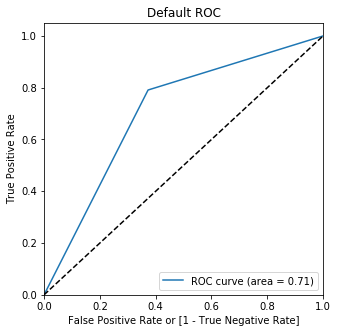

(array([0.        , 0.37275788, 1.        ]),
 array([0.        , 0.79115185, 1.        ]),
 array([2., 1., 0.]))

In [129]:
draw_roc(y_test, y_pred)

[[12484  7419]
 [ 4192 15880]]


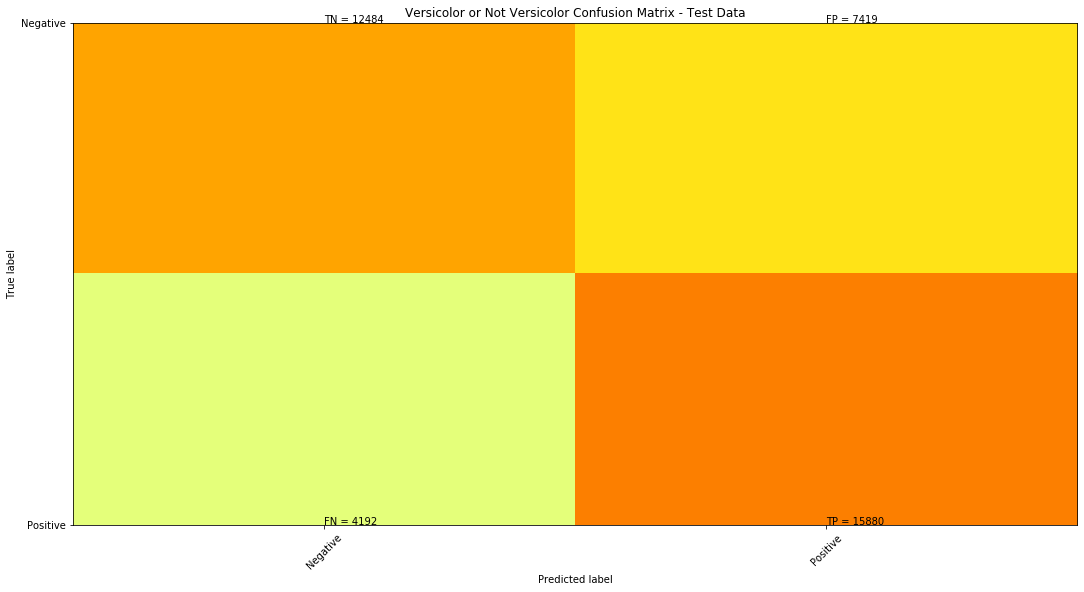

In [141]:
# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cmlr)
import seaborn as sns
import matplotlib.pyplot as plt    

plt.figure(figsize = (18,16)) 
plt.clf()
plt.imshow(cmlr, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmlr[i][j]))
plt.show()

## Step 11: Model Selection

Criteria for model selection: *<font color = blue>It is is more important to identify Default than the non-Default accurately.</font>*

#### We started out with a simple linear model (Logistic Regression) and then eventually moved to more complex models.
#### Below is a short summary of all the models built to predict Default customers:

|Model|Accuracy|Precision|Recall|F1 Score|AUC|
|-----|-----|-----|-----|-----|-----|
|`Logistic Regression with Demographic data with WOE`|0.96|0.00|0.00|0.00|0.50|
|`Logistic Regression with Demographic over sample data with WOE`|0.57|0.58|0.54|0.56|0.57|
|`Logistic Regression with Merge over sample data with WOE`|0.65|0.63|0.73|0.67|0.65|
|`Random Forest with Merge over sample data with WOE`|0.69|0.67|0.75|0.71|0.69|
|`Random Forest with Merge over sample data without WOE`|0.72|0.68|0.79|0.73|0.72|

`Sensitivity` in our context can be defined as a measure of total no of actual Default correctly predicted out of the total no of actual Default. It is also referred to as `True Positive Rate` or simple as `Recall`.

The business goal here is to identify Default more accurately than to identify the non-Default. Hence the evaluation metric that satisfies the business goal is Sensitivity.

From the above table, we see that the Random Forest Model has the best value for Sensitivity(79%).ie. the model can accurately predict 79% of the Default customers.

`Hence our chosen model is the Random Forest Model.`

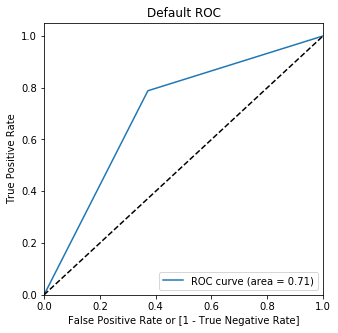

(array([0.        , 0.37205446, 1.        ]),
 array([0.        , 0.78821244, 1.        ]),
 array([2., 1., 0.]))

In [292]:
# Roc Curv
draw_roc(y_test, y_pred)

#### We got the accuracy of 71% for the random forest model for raw data without using WOE

In [69]:
rfc_raw.feature_importances_

array([0.00280312, 0.00946394, 0.04831466, 0.00887335, 0.01645056,
       0.03571087, 0.21694542, 0.01012804, 0.06198012, 0.01895087,
       0.10641237, 0.02350321, 0.08791608, 0.00229025, 0.07099659,
       0.03388059, 0.00246565, 0.04176468, 0.01797214, 0.04375265,
       0.05636056, 0.04890844, 0.00413347, 0.00266673, 0.01189685,
       0.01037375, 0.00508503])

In [70]:

# Putting features into a variable
features = list(master_df_performance_sampled_raw.drop(['performance_tag'], axis=1).columns[:])
features

['no_of_times_90_dpd_or_worse_in_last_6_months',
 'no_of_times_60_dpd_or_worse_in_last_6_months',
 'no_of_times_30_dpd_or_worse_in_last_6_months',
 'no_of_times_90_dpd_or_worse_in_last_12_months',
 'no_of_times_60_dpd_or_worse_in_last_12_months',
 'no_of_times_30_dpd_or_worse_in_last_12_months',
 'avgas_cc_utilization_in_last_12_months',
 'no_of_trades_opened_in_last_6_months',
 'no_of_trades_opened_in_last_12_months',
 'no_of_pl_trades_opened_in_last_6_months',
 'no_of_pl_trades_opened_in_last_12_months',
 'no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans',
 'no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans',
 'presence_of_open_home_loan',
 'outstanding_balance',
 'total_no_of_trades',
 'presence_of_open_auto_loan',
 'age',
 'no_of_dependents',
 'income',
 'no_of_months_in_current_residence',
 'no_of_months_in_current_company',
 'gender',
 'marital_status_at_the_time_of_application',
 'education',
 'profession',
 'type_of_residence']

### feature importances

In [71]:
# Capturing the feature importances from the tree model properties into a dataframe and seleting the top 10 features
feature_importance = rfc_raw.feature_importances_
fi = pd.concat([pd.DataFrame(features), pd.DataFrame(feature_importance)], axis = 1)
fi.columns = ['Features','Importance']
fi_sorted = fi.loc[fi['Importance']>0].sort_values(by=['Importance'],ascending=False)
fi_sorted_top10 = fi_sorted.head(10)
fi_sorted_top10

,Features,Importance
6,avgas_cc_utilization_in_last_12_months,0.217
10,no_of_pl_trades_opened_in_last_12_months,0.106
12,no_of_inquiries_in_last_12_months_excluding_ho...,0.088
14,outstanding_balance,0.071
8,no_of_trades_opened_in_last_12_months,0.062
20,no_of_months_in_current_residence,0.056
21,no_of_months_in_current_company,0.049
2,no_of_times_30_dpd_or_worse_in_last_6_months,0.048
19,income,0.044
17,age,0.042


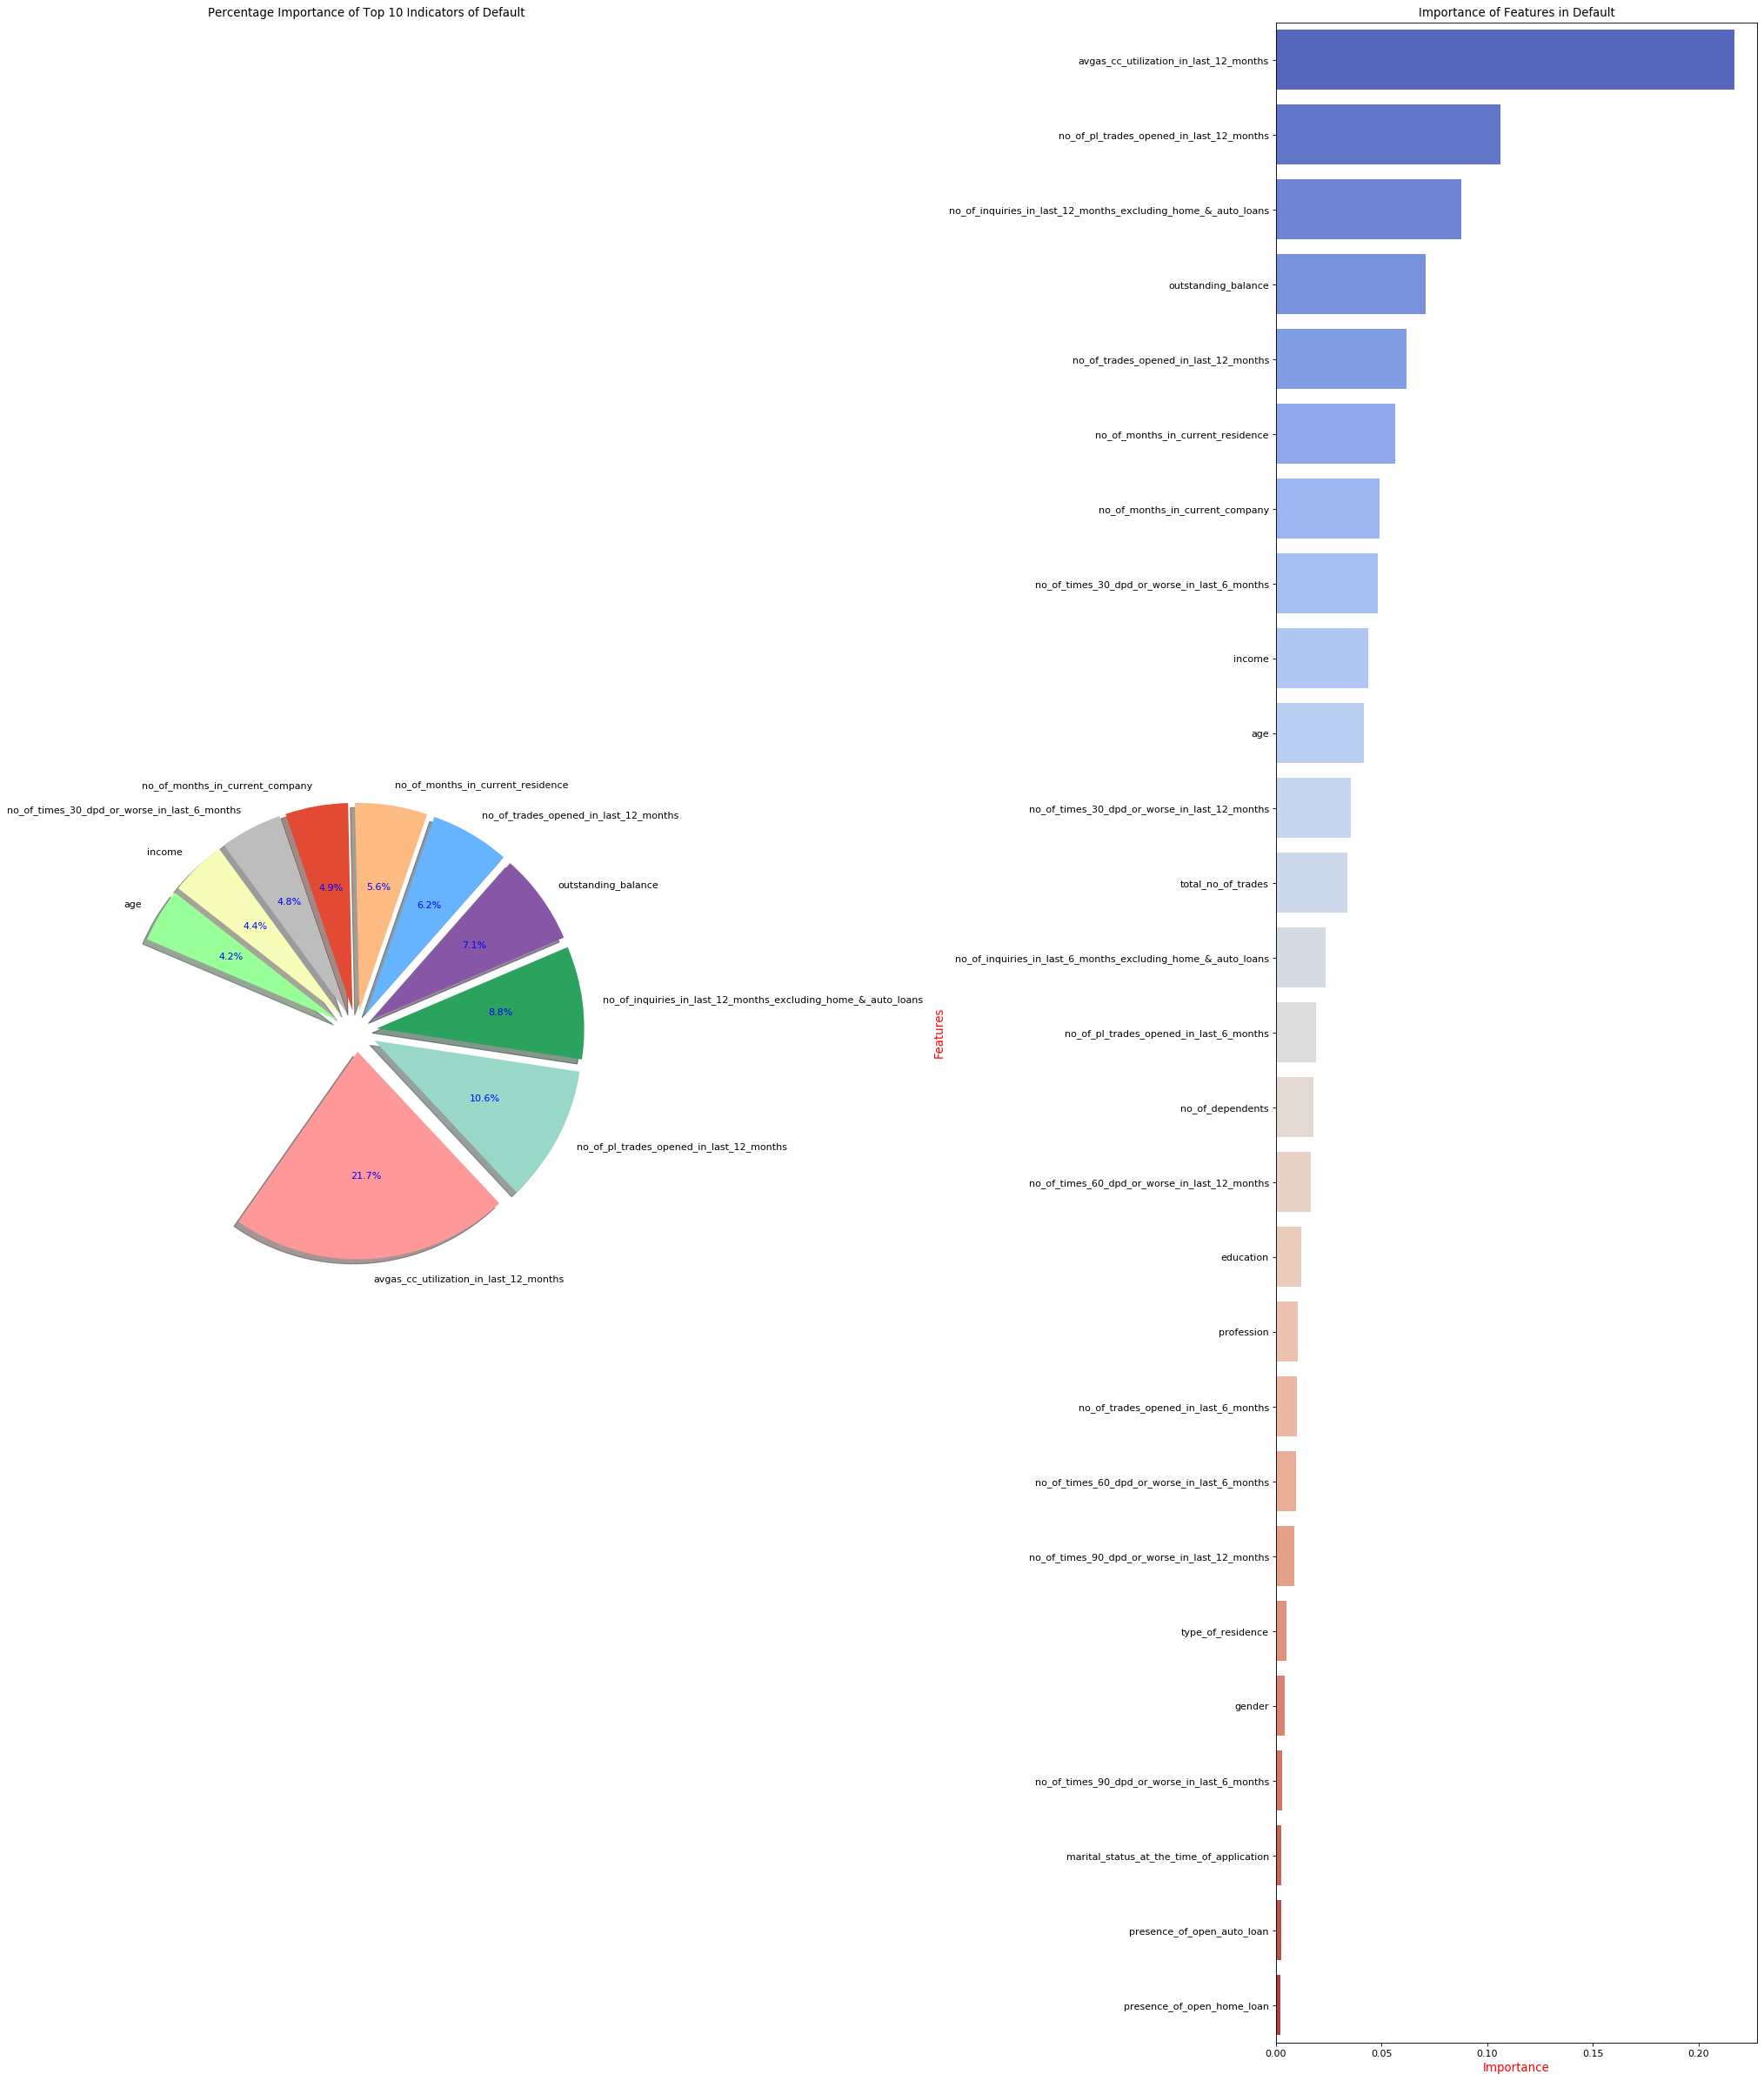

In [72]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(25,30), dpi=80, facecolor='w', edgecolor='k', frameon='True')
pal = ["#ff9999", "#99d8c9", "#2ca25f", "#8856a7","#66b3ff","#fdbb84","#e34a33","#bdbdbd","#f7fcb9","#99ff99","#f7fcb9","#fec44f","#d95f0e","#dd1c77","#99ff99"]
names = list(fi_sorted_top10.Features)
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1)

# subplot 1
plt.subplot(1, 2, 1)
patches, texts, autotexts = plt.pie(fi_sorted_top10['Importance'], labels=names, startangle=235, colors = pal, autopct='%.1f%%',shadow=True,explode=explode)
plt.title("Percentage Importance of Top 10 Indicators of Default",fontsize=12)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
for autotext in autotexts:
    autotext.set_color('blue')

# subplot 2
plt.subplot(1, 2, 2)
sns.barplot(y='Features', x='Importance', palette='coolwarm', data=fi_sorted, estimator=np.sum)
plt.yticks(size = 10)
plt.title("Importance of Features in Default",fontsize=12)
plt.xlabel('Importance', fontsize = 12, color='r')
plt.ylabel('Features', fontsize = 12, color='r')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()


### Optimal cutoff


In [144]:
y_train_pred_prob =rfc_raw.predict_proba(X_train)[:, 1]
y_train_pred_prob[:10]

array([0.1189246 , 0.60535079, 0.15010324, 0.7032849 , 0.35087873,
       0.15104645, 0.5813528 , 0.70732547, 0.51013426, 0.66284154])

In [145]:
y_train_pred_final = pd.DataFrame({'Responce':y_train.values, 'Responce_Prob':y_train_pred_prob})
y_train_pred_final.head()

,Responce,Responce_Prob
0,0.000,0.119
1,1.000,0.605
2,0.000,0.150
3,1.000,0.703
4,0.000,0.351


In [146]:
#Lets consider probablity .5
y_train_pred_final['predicted'] = y_train_pred_final.Responce_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Responce,Responce_Prob,predicted
0,0.000,0.119,0
1,1.000,0.605,1
2,0.000,0.150,0
3,1.000,0.703,1
4,0.000,0.351,0


In [147]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Responce_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Responce,Responce_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.000,0.119,0,1,1,0,0,0,0,0,0,0,0
1,1.000,0.605,1,1,1,1,1,1,1,1,0,0,0
2,0.000,0.150,0,1,1,0,0,0,0,0,0,0,0
3,1.000,0.703,1,1,1,1,1,1,1,1,1,0,0
4,0.000,0.351,0,1,1,1,1,0,0,0,0,0,0


In [148]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Responce, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

       prob  accuracy  sensi  speci
0.000 0.000     0.499  1.000  0.000
0.100 0.100     0.508  1.000  0.017
0.200 0.200     0.565  1.000  0.131
0.300 0.300     0.638  0.957  0.320
0.400 0.400     0.686  0.900  0.473
0.500 0.500     0.714  0.795  0.634
0.600 0.600     0.713  0.580  0.846
0.700 0.700     0.578  0.162  0.993
0.800 0.800     0.502  0.003  1.000
0.900 0.900     0.501  0.000  1.000


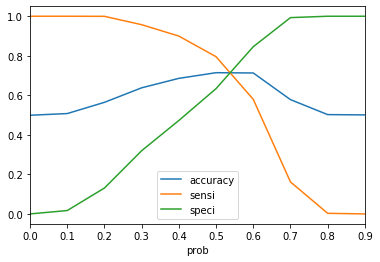

In [149]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.55 is the optimum point to take it as a cutoff probability for Train data set

In [150]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Responce_Prob.map( lambda x: 1 if x > 0.55 else 0)

y_train_pred_final.head()

,Responce,Responce_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0.000,0.119,0,1,1,0,0,0,0,0,0,0,0,0
1,1.000,0.605,1,1,1,1,1,1,1,1,0,0,0,1
2,0.000,0.150,0,1,1,0,0,0,0,0,0,0,0,0
3,1.000,0.703,1,1,1,1,1,1,1,1,1,0,0,1
4,0.000,0.351,0,1,1,1,1,0,0,0,0,0,0,0


In [151]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Responce, y_train_pred_final.final_predicted))

0.7285173630096599


In [152]:
y_test_prob=rfc_raw.predict_proba(X_test)[:, 1]
y_test_prob[:10]

array([0.3638579 , 0.60723559, 0.18853056, 0.62401423, 0.58793903,
       0.10646169, 0.68310289, 0.21874588, 0.25833028, 0.18303292])

In [153]:
# Create data frmae of y test
y_test_pred_final = pd.DataFrame({'Responce':y_test.values, 'Responce_Prob':y_test_prob})
y_test_pred_final.head()

,Responce,Responce_Prob
0,1.000,0.364
1,0.000,0.607
2,0.000,0.189
3,1.000,0.624
4,0.000,0.588


In [154]:
y_test_pred_final.reset_index(drop=True, inplace=True)
y_train_pred_final.reset_index(drop=True, inplace=True)

In [155]:
y_train_pred_final.head()

,Responce,Responce_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0.000,0.119,0,1,1,0,0,0,0,0,0,0,0,0
1,1.000,0.605,1,1,1,1,1,1,1,1,0,0,0,1
2,0.000,0.150,0,1,1,0,0,0,0,0,0,0,0,0
3,1.000,0.703,1,1,1,1,1,1,1,1,1,0,0,1
4,0.000,0.351,0,1,1,1,1,0,0,0,0,0,0,0


In [156]:
# Append both data set into one
y_pred_final=y_test_pred_final.append(y_train_pred_final) 

In [157]:
# Select only 
y_pred_final_df=y_pred_final[['Responce','Responce_Prob']]
y_pred_final_df_temp=y_pred_final_df

In [158]:
y_pred_final_df_temp.head()

,Responce,Responce_Prob
0,1.000,0.364
1,0.000,0.607
2,0.000,0.189
3,1.000,0.624
4,0.000,0.588


       prob  accuracy  sensi  speci
0.000 0.000     0.500  1.000  0.000
0.100 0.100     0.509  1.000  0.017
0.200 0.200     0.565  1.000  0.130
0.300 0.300     0.638  0.957  0.319
0.400 0.400     0.685  0.899  0.471
0.500 0.500     0.713  0.794  0.632
0.600 0.600     0.711  0.577  0.844
0.700 0.700     0.575  0.158  0.992
0.800 0.800     0.501  0.003  1.000
0.900 0.900     0.500  0.000  1.000


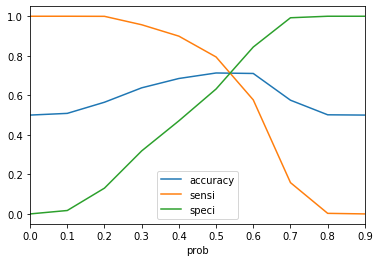

In [159]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final_df_temp[i]= y_pred_final_df_temp.Responce_Prob.map(lambda x: 1 if x > i else 0)
y_pred_final_df_temp.head()

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df1 = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_pred_final_df_temp.Responce, y_pred_final_df_temp[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df1.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df1)

# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df1.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.55 is the optimum point to take it as a cutoff probability for complete data set

In [160]:
y_pred_final_df['final_predicted'] = y_pred_final_df.Responce_Prob.map(lambda x: 1 if x > 0.55 else 0)

In [161]:
y_pred_final_df.head()

,Responce,Responce_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1.000,0.364,1,1,1,1,0,0,0,0,0,0,0
1,0.000,0.607,1,1,1,1,1,1,1,0,0,0,1
2,0.000,0.189,1,1,0,0,0,0,0,0,0,0,0
3,1.000,0.624,1,1,1,1,1,1,1,0,0,0,1
4,0.000,0.588,1,1,1,1,1,1,0,0,0,0,1


In [167]:
y_pred_final_df.shape

(133248, 13)

In [162]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final_df.Responce, y_pred_final_df.final_predicted)

0.7261647454370798

In [75]:
y_overall=rfc_raw.predict_proba(X)[:, 1]
y_overall

array([0.08424773, 0.18722008, 0.08034738, ..., 0.63832782, 0.52615314,
       0.66684221])

In [128]:
# Create data frmae of y test
overall = pd.DataFrame({'Responce':y.values, 'Responce_Prob':y_overall})
overall.head()

,Responce,Responce_Prob
0,0.000,0.084
1,0.000,0.187
2,0.000,0.080
3,0.000,0.105
4,0.000,0.150


In [77]:
df_final = pd.merge(overall, master_df_performance_unsampled_cleaned[['application_id','performance_tag']], left_index=True, right_index=True)

In [168]:
df_final.head()

,Responce,Responce_Prob,application_id,performance_tag,final_predicted,p_bad,p_good,Odds,log_ods,score
1676,0.000,0.032,98023657,0.000,0,0.032,0.968,30.347,3.413,432.000
249,0.000,0.034,930294497,0.000,0,0.034,0.966,28.050,3.334,430.000
557,0.000,0.036,20382564,0.000,0,0.036,0.964,26.638,3.282,428.000
5187,0.000,0.039,331735839,0.000,0,0.039,0.961,24.622,3.204,426.000
2029,0.000,0.040,429614023,0.000,0,0.040,0.960,24.211,3.187,426.000


### Application Score card

In [170]:
df_final['final_predicted'] = df_final.Responce_Prob.map(lambda x: 1 if x > 0.55 else 0)

[[48265 18359]
 [ 1504  1435]]


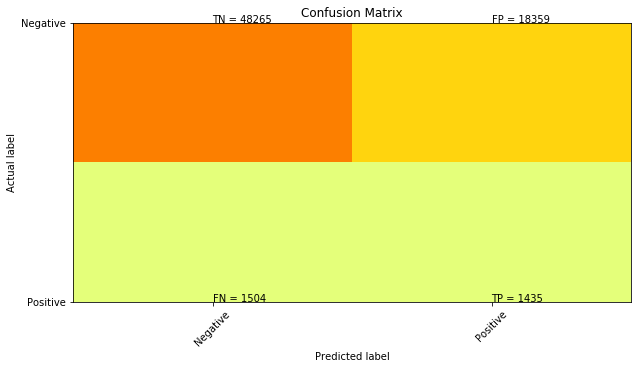

In [171]:
# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=df_final['performance_tag'], y_pred=df_final['final_predicted'])
print(cmlr)
import seaborn as sns
import matplotlib.pyplot as plt    

plt.figure(figsize = (10,6)) 
plt.clf()
plt.imshow(cmlr, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cmlr[i][j]))
plt.show()

In [80]:
df_final['p_bad'] = df_final.Responce_Prob

In [81]:
df_final['p_good'] = 1-df_final.Responce_Prob

In [82]:
df_final['Odds'] = df_final.p_good/df_final.p_bad

In [83]:
df_final['log_ods']=np.log(df_final['Odds'])

In [325]:
#df_final['log_ods']=np.log((df_final.p_good/(1-df_final.p_good)))

In [84]:
# Set up Scoring Logic
target_score = 400
target_odds = 10
pts_double_odds = 20
factor = pts_double_odds / np.log(2)
offset = target_score - (factor * np.log(target_odds))

In [85]:
# Score
df_final['score'] = round(offset + (factor * df_final['log_ods']),0)

In [86]:
df_final[df_final.p_bad>0.55].head(1)

,Responce,Responce_Prob,application_id,performance_tag,final_predicted,p_bad,p_good,Odds,log_ods,score
902,0.000,0.558,858061683,0.000,1,0.558,0.442,0.792,-0.233,327.000


<Figure size 1296x1152 with 0 Axes>

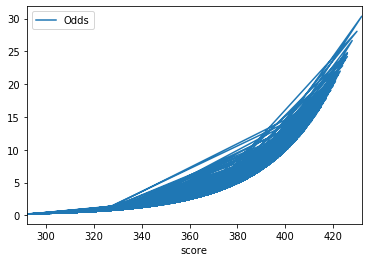

In [87]:
#### Plotting Score Vs Odds
plt.figure(figsize = (18,16)) 
df_final.plot(x='score', y='Odds')
plt.show()

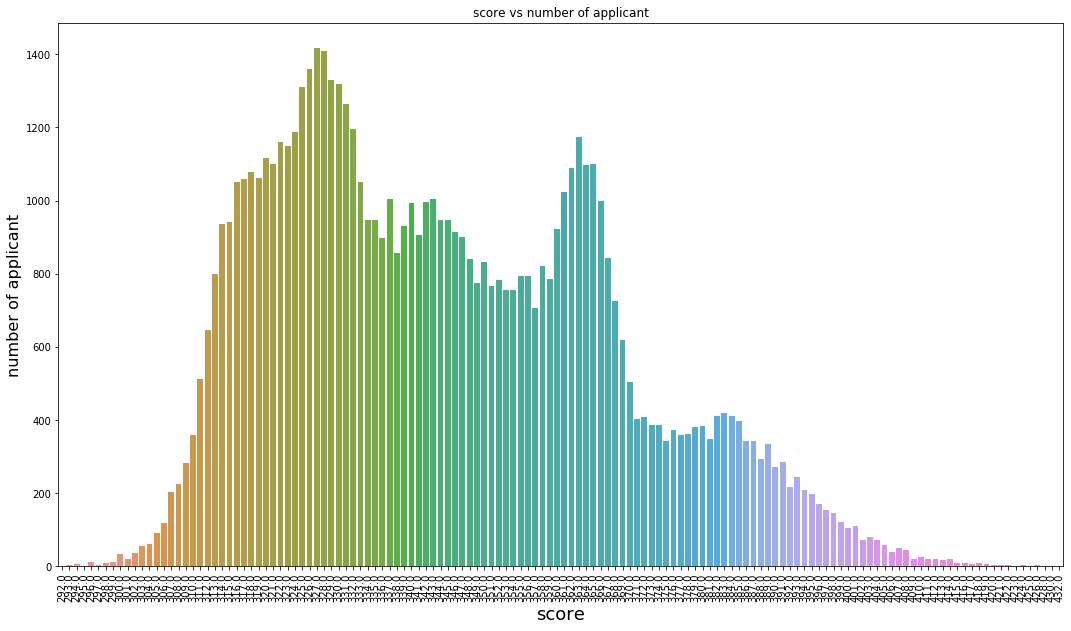

In [127]:
## Distribution of the scorecard score variable 
plt.figure(figsize = (18,10)) 
ax =sns.countplot(x='score', data=df_final)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('score vs number of applicant')
plt.xlabel('score', fontsize=18)
plt.ylabel('number of applicant', fontsize=16)
plt.show()

<Figure size 1440x1152 with 0 Axes>

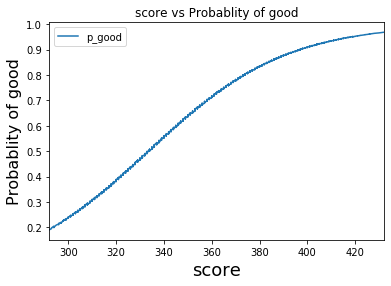

In [118]:
#### Let's see how scores correlate to our probability of being good or bad credit customers for our business
plt.figure(figsize = (20,16)) 
df_final.plot(x='score', y='p_good')
plt.title('score vs Probablity of good')
plt.xlabel('score', fontsize=18)
plt.ylabel('Probablity of good', fontsize=16)
plt.show()

<Figure size 3600x4032 with 0 Axes>

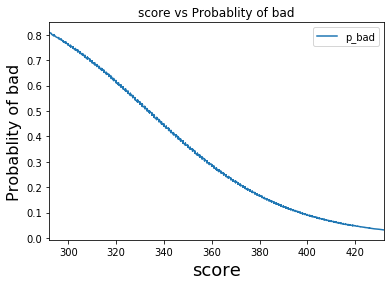

In [121]:
#### Let's see how scores correlate to our probability of being good or bad credit customers for our business
plt.figure(figsize = (50,56)) 
df_final.plot(x='score', y='p_bad')
plt.title('score vs Probablity of bad')
plt.xlabel('score', fontsize=18)
plt.ylabel('Probablity of bad', fontsize=16)
plt.show()

### We got cutoff score of 327

In [90]:
#% of People defaulted
print("% of people defaulted without Model : 4.22%")
print("% of people defaulted according to score card",round(100*(df_final['final_predicted'][df_final['score']<327].count()/df_final['final_predicted'].count()).round(2),0),'%')

% of people defaulted without Model : 4.22%
% of people defaulted according to score card 26.0 %


In [91]:
df_final.sort_values(["score"], axis=0,ascending=False, inplace=True)
df_final.head()

,Responce,Responce_Prob,application_id,performance_tag,final_predicted,p_bad,p_good,Odds,log_ods,score
1676,0.000,0.032,98023657,0.000,0,0.032,0.968,30.347,3.413,432.000
249,0.000,0.034,930294497,0.000,0,0.034,0.966,28.050,3.334,430.000
557,0.000,0.036,20382564,0.000,0,0.036,0.964,26.638,3.282,428.000
5187,0.000,0.039,331735839,0.000,0,0.039,0.961,24.622,3.204,426.000
2029,0.000,0.040,429614023,0.000,0,0.040,0.960,24.211,3.187,426.000


In [92]:
print('Without Model default:',df_final.Responce.sum())
print('Using Model default:',df_final.final_predicted.sum())

Without Mode default: 3248.0
Using Model default: 19794


In [93]:
# Total applicants who have defaulted and model has predicted as likely to default
df_final[(df_final['score']<327) & (df_final['performance_tag']==1)].application_id.count()

1337

In [94]:
# Total applicants who have defaulted and model has predicted as not likely to default
df_final[(df_final['score']>=327) & (df_final['performance_tag']==1)].application_id.count()

1602

In [95]:
# Total applicants who have not defaulted and model has predicted as not likely to default
df_final[(df_final['score']>=327) & (df_final['performance_tag']==0)].application_id.count()

49966

In [96]:
# Total applicants who have not defaulted and model has predicted as likely to default
df_final[(df_final['score']<327) & (df_final['performance_tag']==0)].application_id.count()

16658

#### Current Percentage of defaulter 4.22 %

In [97]:
# credit loss based on model prediction which model rejected some bad customers
print(round(1350/(1350 + 1589 + 16873 + 49751) *100,2),'%')

1.94 %


In [98]:
# Credit loss saved
4.22 - 1.94 
# 2.28%

2.28

In [99]:
# Revenue Los : bad customer likely to default according to model out of good customer
print(round(16873/(49751 + 16873) *100,2),'%')
# 25.33 %

25.33 %


### Analysis of performance tag null 

In [100]:
master_df_null.head()

,application_id,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
69609,906908303,0,0,2,1,2,3,30.000,4.000,12,...,35,M,Single,1.000,6.000,Bachelor,SAL,Rented,22,18
69610,10990583,1,1,1,3,2,2,16.000,3.000,7,...,47,F,Married,4.000,12.000,Masters,SE,Rented,122,25
69611,589678446,3,4,5,3,5,6,83.000,2.000,7,...,46,M,Married,3.000,7.000,Professional,SE,Rented,10,31
69612,809411322,1,3,4,3,4,5,87.000,2.000,7,...,41,M,Married,3.000,18.000,Masters,SAL,Rented,6,47
69613,150246616,2,2,4,3,2,6,42.000,3.000,7,...,42,F,Married,4.000,17.000,Phd,SAL,Rented,8,49


In [101]:
# Checking null
master_df_null.isnull().sum()

application_id                                                      0
no_of_times_90_dpd_or_worse_in_last_6_months                        0
no_of_times_60_dpd_or_worse_in_last_6_months                        0
no_of_times_30_dpd_or_worse_in_last_6_months                        0
no_of_times_90_dpd_or_worse_in_last_12_months                       0
no_of_times_60_dpd_or_worse_in_last_12_months                       0
no_of_times_30_dpd_or_worse_in_last_12_months                       0
avgas_cc_utilization_in_last_12_months                             35
no_of_trades_opened_in_last_6_months                                0
no_of_trades_opened_in_last_12_months                               0
no_of_pl_trades_opened_in_last_6_months                             0
no_of_pl_trades_opened_in_last_12_months                            0
no_of_inquiries_in_last_6_months_excluding_home_&_auto_loans        0
no_of_inquiries_in_last_12_months_excluding_home_&_auto_loans       0
presence_of_open_hom

In [102]:
master_df_null=master_df_null[master_df_null.education.notnull()]
master_df_null=master_df_null[master_df_null.profession.notnull()]
master_df_null=master_df_null[master_df_null.avgas_cc_utilization_in_last_12_months.notnull()]

In [103]:
master_df_null_model=master_df_null.drop(['performance_tag'],axis=1)
master_df_null_model=master_df_null_model.drop(['application_id'],axis=1)
master_df_null_model.head()

,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,...,age,gender,marital_status_at_the_time_of_application,no_of_dependents,income,education,profession,type_of_residence,no_of_months_in_current_residence,no_of_months_in_current_company
69609,0,0,2,1,2,3,30.000,4.000,12,3,...,35,M,Single,1.000,6.000,Bachelor,SAL,Rented,22,18
69610,1,1,1,3,2,2,16.000,3.000,7,3,...,47,F,Married,4.000,12.000,Masters,SE,Rented,122,25
69611,3,4,5,3,5,6,83.000,2.000,7,2,...,46,M,Married,3.000,7.000,Professional,SE,Rented,10,31
69612,1,3,4,3,4,5,87.000,2.000,7,1,...,41,M,Married,3.000,18.000,Masters,SAL,Rented,6,47
69613,2,2,4,3,2,6,42.000,3.000,7,2,...,42,F,Married,4.000,17.000,Phd,SAL,Rented,8,49


In [104]:
from sklearn import preprocessing


# encode categorical variables using Label Encoder

# select all categorical variables
df_categorical = master_df_null_model.select_dtypes(include=['object'])
df_categorical.head()

,gender,marital_status_at_the_time_of_application,education,profession,type_of_residence
69609,M,Single,Bachelor,SAL,Rented
69610,F,Married,Masters,SE,Rented
69611,M,Married,Professional,SE,Rented
69612,M,Married,Masters,SAL,Rented
69613,F,Married,Phd,SAL,Rented


In [105]:
# apply Label encoder to df_categorical

le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)
df_categorical.head()

,gender,marital_status_at_the_time_of_application,education,profession,type_of_residence
69609,1,1,0,0,4
69610,0,0,1,1,4
69611,1,0,4,1,4
69612,1,0,1,0,4
69613,0,0,3,0,4


In [106]:
# concat df_categorical with original df
master_df_pf_null= master_df_null_model.drop(df_categorical.columns, axis=1)
master_df_pf_null = pd.concat([master_df_pf_null, df_categorical], axis=1)
master_df_pf_null.head()


,no_of_times_90_dpd_or_worse_in_last_6_months,no_of_times_60_dpd_or_worse_in_last_6_months,no_of_times_30_dpd_or_worse_in_last_6_months,no_of_times_90_dpd_or_worse_in_last_12_months,no_of_times_60_dpd_or_worse_in_last_12_months,no_of_times_30_dpd_or_worse_in_last_12_months,avgas_cc_utilization_in_last_12_months,no_of_trades_opened_in_last_6_months,no_of_trades_opened_in_last_12_months,no_of_pl_trades_opened_in_last_6_months,...,age,no_of_dependents,income,no_of_months_in_current_residence,no_of_months_in_current_company,gender,marital_status_at_the_time_of_application,education,profession,type_of_residence
69609,0,0,2,1,2,3,30.000,4.000,12,3,...,35,1.000,6.000,22,18,1,1,0,0,4
69610,1,1,1,3,2,2,16.000,3.000,7,3,...,47,4.000,12.000,122,25,0,0,1,1,4
69611,3,4,5,3,5,6,83.000,2.000,7,2,...,46,3.000,7.000,10,31,1,0,4,1,4
69612,1,3,4,3,4,5,87.000,2.000,7,1,...,41,3.000,18.000,6,47,1,0,1,0,4
69613,2,2,4,3,2,6,42.000,3.000,7,2,...,42,4.000,17.000,8,49,0,0,3,0,4


In [107]:
p_null_predict=rfc_raw.predict_proba(master_df_pf_null)[:, 1]
p_null_predict

array([0.6770951 , 0.46263551, 0.72087362, ..., 0.60639969, 0.71531155,
       0.69561105])

In [108]:
# Create data frmae of y test
p_df = pd.DataFrame({'Responce_Prob':p_null_predict})
p_df.head()

,Responce_Prob
0,0.677
1,0.463
2,0.721
3,0.738
4,0.685


In [109]:
p_df['final_predicted'] = p_df.Responce_Prob.map(lambda x: 1 if x > 0.55 else 0)

p_df['p_bad'] = p_df.Responce_Prob

p_df['p_good'] = 1-p_df.Responce_Prob

p_df['Odds'] = p_df.p_good/p_df.p_bad

p_df['log_ods']=np.log(p_df['Odds'])

In [110]:
p_df['score'] = round(offset + (factor * p_df['log_ods']),0)
p_df.head()

,Responce_Prob,final_predicted,p_bad,p_good,Odds,log_ods,score
0,0.677,1,0.677,0.323,0.477,-0.740,312.000
1,0.463,0,0.463,0.537,1.162,0.150,338.000
2,0.721,1,0.721,0.279,0.387,-0.949,306.000
3,0.738,1,0.738,0.262,0.355,-1.036,304.000
4,0.685,1,0.685,0.315,0.459,-0.778,311.000


### Total applicants who have rejected and model has predicted as likely to not default

In [111]:
# Total applicants who have defaulted and model has predicted as likely to default
p_df[p_df['score']>327].final_predicted.count()

41

We Found 47 applicants rejected upfront was predicted as likely to not default and it was credit loss for company

### Visualization

In [112]:
df_final.describe()

,Responce,Responce_Prob,application_id,performance_tag,final_predicted,p_bad,p_good,Odds,log_ods,score
count,69563.000,69563.000,69563.000,69563.000,69563.000,69563.000,69563.000,69563.000,69563.000,69563.000
mean,0.047,0.418,499246487.855,0.042,0.285,0.418,0.582,2.100,0.393,344.904
std,0.211,0.171,288539235.496,0.201,0.451,0.171,0.171,2.087,0.801,23.105
min,0.000,0.032,100450.000,0.000,0.000,0.032,0.190,0.235,-1.447,292.000
25%,0.000,0.271,248648334.000,0.000,0.000,0.271,0.435,0.771,-0.260,326.000
50%,0.000,0.429,497941975.000,0.000,0.000,0.429,0.571,1.331,0.286,342.000
75%,0.000,0.565,749914292.500,0.000,1.000,0.565,0.729,2.691,0.990,362.000
max,1.000,0.810,1000084142.000,1.000,1.000,0.810,0.968,30.347,3.413,432.000


In [125]:
df_final[df_final['score']>=327].application_id.count()

51568

In [126]:
df_final[df_final['score']<327].application_id.count()

17995